### ) Import Packages

In [1]:
from scipy import interpolate
from scipy import integrate
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def get_batch(y, t, knots, iteration, mode, idx_describe=False):
    np.random.seed(iteration)
    print('\nSeed= ', iteration)

    if mode == "uniform":
        idx = np.arange(0, t.shape[0], int(t.shape[0]/knots))
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots

    elif mode == "midpoint":
        t_knots = np.array([t[t.shape[0]//2]])
        return t_knots

    elif mode == "three_knots":
        t_knots = np.array([t[0],t[t.shape[0]//2],t[-1]])
        idx=np.array([0,t.shape[0]//2,t.shape[0]-1])
        if idx_describe==True:
            return t_knots,idx
        else:
            return t_knots

    elif mode == "random_end":
        t_shape = t.shape[0]//10
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        idx = (t_shape*9) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots

    elif mode == "random_start":
        t_shape = t.shape[0]//10
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots        

    elif mode == "random_middle":
        t_shape = t.shape[0]//10
        #t_shape=int(t.shape[0]*0.3)
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        idx= int(t_shape*4.5) + idx
        #idx= int(t.shape[0]*0.35) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
        
    elif mode == "random_middle_more":
        #t_shape = t.shape[0]//10
        t_shape=int(t.shape[0]*0.4)
        idx = np.random.choice(t_shape, size=knots, replace=False)
        idx = np.sort(idx)
        #idx= int(t_shape*4.5) + idx
        idx= int(t.shape[0]*0.3) + idx
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
    
    elif mode == "random_more_at_middle":
        t_shape=t.shape[0]//4
        idx = np.random.choice(len(t), size=int(knots*0.4), replace=False)
        idx_ = np.random.choice(t_shape, size=int(knots*0.6), replace=False)
        #idx_2=idx_
        idx_ = int(t_shape*1.5) + idx_
        idx=np.concatenate((idx, idx_), axis=0)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
        
    elif mode == "random_more_at_ends":
        t_shape=t.shape[0]//5
        idx = np.random.choice(len(t), size=int(knots*0.4), replace=False)
        idx_ = np.random.choice(t_shape, size=int(knots*0.3), replace=False)
        idx_2=idx_
        idx_ = (t_shape*4) + idx_
        idx=np.concatenate((idx, idx_,idx_2), axis=0)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots
    
    elif mode == "random":
        idx = np.random.choice(len(t), size=knots, replace=False)
        idx = np.sort(idx)
        t_knots = np.array(t[idx])
        if idx_describe == True:
            return t_knots, idx
        else:
            return t_knots


    else:
        t_knots = np.array([])
        return t_knots

### ) Get Tau Forward and Tau Backward

In [3]:
def get_tau(y, t, ti, describe=False):
    '''Provides the time instants for the forward and backward kernel integration
    >>> get_tau(y, t, ti=3)
    >>> t.shape (10,)
            ti=  3
            tau_F=  [0.         0.66666667 1.33333333 2.         2.66666667]
            tau_B=  [3.33333333 4.         4.66666667 5.33333333 6.        ]
    '''

    F_indices = np.where(t <= ti)[0]
    B_indices = np.where(t > ti)[0]
    tau_F = t[F_indices]
    tau_B = t[B_indices]
    
    if describe == True:
        print('\nCalled get_tau function\n')
        print('t.shape', t.shape)
        print('time instant= ', ti)
        print('tau_F= ', tau_F)
        print('tau_B= ', tau_B)
    return tau_F, tau_B

### Calculate Annihilator Terms

In [4]:
def get_alpha_tau(ti, tau_F, tau_B, a, b, n, order, describe=False):
    '''Provides the multiplication of LHS elements i.e [(t-a)**4 X (t-s)**(n-1)]/(n-1)! for integration
    >>> get_alpha_tau(ti, tau_F, tau_B, a, b, n=1,describe=True)
    >>> ti=  3
            tau_F=  [0.         0.66666667 1.33333333 2.         2.66666667]
            tau_B=  [3.33333333 4.         4.66666667 5.33333333 6.        ]
            alpha_F=  [ 0.          0.19753086  3.16049383 16.         50.56790123]
            alpha_B=  [50.56790123 16.          3.16049383  0.19753086  0.        ]
            alpha_concatenated=  [ 0.          0.19753086  3.16049383 16.         50.56790123 50.56790123
             16.          3.16049383  0.19753086  0.        ]
    '''
    f = np.math.factorial
    
    # Calculate alpha forward
    delta_time_F = np.array((ti - tau_F)**(n-1))
    delta_tau_F = np.array((tau_F - a)**order) #changed
    alpha_F = np.multiply(delta_time_F, delta_tau_F)
    
    # Calculate alpha backward
    delta_time_B = np.array((ti - tau_B)**(n-1))
    delta_tau_B = np.array((b - tau_B)**order) #changed
    alpha_B = np.multiply(delta_time_B, delta_tau_B)

    alpha = np.concatenate((alpha_F, alpha_B), axis=0)
    alpha_ = np.array(alpha)

    if describe == True:
        print('\nCalled get_alpha_tau function\n')
        print('n (integral order)=', n)
        print('time instant= ', ti)
        print('tau_F= ', tau_F)
        print('tau_B= ', tau_B)
        print('alpha_F= ', alpha_F)
        print('alpha_B= ', alpha_B)
        print('alpha_concatenated= ', alpha)
        print('*'*10)

    return alpha_

### ) Calculate Kernels for Q and P Matrices

In [5]:
def get_KFn_vector(ti, tau_F, a, n, order):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(tau_F - a)

    for i in range(0, order):
        gamma[i, :] = np.array((((ti - tau_F)**(n+i))*f(n-1))/(f(n+i)))
    #a=0.0
    for j in range(1, order+1):
        zeta[order,:]= zeta[order,:]+( ((-1)**(j+1)) * gamma[j-1, :] * ((delta**(order-j))/f(order-j))  * (f(order)/(f(j)*f(order-j))) * f(order))# *(np.ones(N_tau))) #const
    #print('outp ',zeta[order,:])
    #print('ti',ti)
    #print('tauF',tau_F)
    for i in range(0, order):    
        #zeta[i,:]=np.zeros(N_tau)
        if i==0:
            j=0
            zeta[i,:]= zeta[i,:]+(gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i,:]= zeta[i,:]+(gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        #print('outpu ',zeta[i,:])
    return zeta

In [6]:
def get_KBn_vector(ti, tau_B, b, n,order):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - tau_B)

    for i in range(0, order):
        gamma[i, :] = np.array((((ti - tau_B)**(n+i))*f(n-1))/(f(n+i)))

    for j in range(1, order+1):
        zeta[order,:]= zeta[order,:]+(gamma[j-1, :] * ((delta**(order-j))/f(order-j)) * (f(order)/(f(j)*f(order-j))) * f(order))# *(np.ones(N_tau))) #const
    #print('outpB ',zeta[order,:])
    
    #print('ti',ti)
    #print('tauB',tau_B)   
    
    for i in range(0, order):    
        #zeta[i,:]=np.zeros(N_tau)
        if i==0:
            j=0
            zeta[i,:]=zeta[i,:]+ (gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i,:]=zeta[i,:]+ (gamma[order-i+j-1, :] * ((delta**(order-j))/f(order-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        #print('outpuB ',zeta[i,:])
    if n > 0:
        zeta = np.array(-1.0*zeta)
    return zeta

### ) Calculate Kernels for S Matrix

In [7]:
def get_KDSn(ti, tau_F, tau_B, a, b, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
    KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
    KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)

    KDSn = np.multiply(beta, KDSn_vector)
    KDSn = np.sum(KDSn, axis=0)
    return KDSn


def get_KFn(ti, tau_F, a, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
    KFn = np.multiply(beta, KFn_vector)
    KFn = np.sum(KFn, axis=0)
    return KFn


def get_KBn(ti, tau_B, b, n, order, ak):
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)

    KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
    KBn = np.multiply(beta, KBn_vector)
    KBn = np.sum(KBn, axis=0)
    return KBn

### ) Calculate LHS

In [8]:
def get_LHS(y, t, tk, a, b, n, order, describe=False):
    f = np.math.factorial
    N = tk.shape[0]  # t_knots

    #print('\nstart time ',tk)
    if describe == True:
        print('\nCalculating get_LHS function\n')
        print('t_knots=', tk)

    LHS_n = np.zeros(N)
    r = 0
    for ti in tk:
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate alpha
        alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n, order, describe)
        # Calculate Integrand:
        integrand = np.multiply(alpha, y)
        # Integrate
        integral = np.trapz(integrand, t)
        # Store value
        LHS_n[r] = np.array((integral))
        r += 1
        
    return LHS_n

### ) Calculate RHS

In [9]:
def get_RHS(y, t, tk, a, b, n, order, describe=False):
    f = np.math.factorial
    N = tk.shape[0]
    #print('start time ',tk)
    RHS_n = np.zeros((N, order+1))
    r = 0
    for ti in tk:
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate Kernel vector
        KFn_vector = get_KFn_vector(ti, tau_F, a, n,order)
        KBn_vector = get_KBn_vector(ti, tau_B, b, n,order)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)

        if describe == True:
            print('\nCalculating get_RHS function\n')
            print('KFn=', KFn_vector)
            print(KFn_vector.shape)
            print('KBn=', KBn_vector)
            print(KBn_vector.shape)
            print('KDS=', KDSn_vector)
        # Calculate integrands
        integrand = np.multiply(KDSn_vector, y)
        # Integrate
        for k in range(0, order+1):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
        r += 1

    return RHS_n

### ) Calculate P and Q matrices

In [10]:
def get_P_Q(y, t, tk, a, b, order, n_min=1, n_max=5, describe=False, plot=False):
    f = np.math.factorial

    # n_min = 1#n_max-4
    n_vector = np.arange(n_min, n_max)

    for n in n_vector:
        #print('\n n= ', n)
        LHS_n = get_LHS(y, t, tk, a, b, n, order, describe)
        RHS_n = get_RHS(y, t, tk, a, b, n, order, describe)

        if n == n_vector[0]:
            LHS = np.array(LHS_n)
            RHS = np.array(RHS_n)
        else:
            LHS = np.concatenate((LHS, LHS_n), axis=None)
            RHS = np.vstack((RHS, RHS_n))

    # Arrange P:
    P = np.array(RHS[:, 0:order])
    # Arrange Q:
    Q = np.subtract(LHS, RHS[:, order])
    
    print('\n')
    print('\nCalculating get_PQ function\n')
    rank = np.linalg.matrix_rank(P)
    print("\nRank of the Matrix P is : ", rank)
    #####determinant=np.linalg.det(P)
    #####print("\nDeterminant of the Matrix P is : ", determinant)
    #print('\nP shape= ',P.shape)
    #print('\nP= ',P)
    #print('\nQ shape=',Q.shape)
    #print('\nQ= ',Q)
    
    Pin = np.linalg.pinv(P)
    a_est = np.matmul(Pin, Q)
    
    if describe == True:
        print('\nParameter Estimates for individual eqns')
        for i in range(1, n_max-n_min+1):
            print('\nn= ', n_min-1+i)
            #print('\nP=', P[knots*(i-1):knots*i])
            #print('\nQ=', Q[knots*(i-1):knots*i])
            print('parameter=', np.matmul(np.linalg.pinv(
                P[knots*(i-1):knots*i]), Q[knots*(i-1):knots*i]))
            print('\na_est= ',a_est)
    
    if plot == True:
        plt.figure(figsize=(10, 7))
        for i in range(1, n_max-n_min+1):
            lab = 'Integration No.= '+str(n_min-1+i)
            plt.title('Error $(LHS-RHS)$')
            shape=a_est.shape[0]
            value=RHS[knots*(i-1):knots*i, shape]
            #print('val_co',value)
            for j in range(0,shape):
                value=value+RHS[knots*(i-1):knots*i, j]*a_est[j]
                #print('value',value)
            plt.plot(tk, LHS[knots*(i-1):knots*i]-value, label=lab)     
            #plt.plot(tk, LHS[knots*(i-1):knots*i]-(RHS[knots*(i-1):knots*i, 0]*a_est[0]+RHS[knots*(i-1):knots*i, 1]*a_est[1] +
           #                                        RHS[knots*(i-1):knots*i, 2]*a_est[2]+RHS[knots*(i-1):knots*i, 3]), label=lab)
            plt.xlabel('Time (sec)')
            plt.ylabel('LHS - RHS')
            plt.legend(loc='best')
            
        
        for i in range(1, n_max-n_min+1):
            plt.figure(figsize=(10, 7))
            lab = 'Integrating both LHS and RHS '+str(n_min-1+i)+' times'
            #ab = 'Integrating RHS '+str(n_min-1+i)+' times'
            plt.title(lab)
            shape=a_est.shape[0]
            value=RHS[knots*(i-1):knots*i, shape]
            for j in range(0, shape):
                value=value+RHS[knots*(i-1):knots*i, j]*a_est[j]
                
            plt.plot(tk, LHS[knots*(i-1):knots*i], label='LHS')
            plt.plot(tk, value, label='RHS')
            plt.xlabel('Time (sec)')
            plt.legend(loc='best')

    return P, Q

In [11]:
# Diagonal Covariance Matrix
def get_S(y, t, tk, a, b, order, ak,  n_min, n_max,var):
    print(n_min,n_max)
    f = np.math.factorial

    N = tk.shape[0]

    n_vector = np.arange(n_min, n_max)  # n_max - 4

    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))

    m = 0
    for n in n_vector:
        Cov_inv = np.zeros((N, N))

        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, order, ak)
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n,order)
            integrand = np.array((alpha - KDSn)**2)

            Cov = np.array((var**2)*(np.trapz(integrand, t)))
            # np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
            Cov_inv[r1, r1] = np.array(1/Cov)
            # print('**r1**\n',r1)
            # print('***Cov***\n',Cov)
            # print('******\n\n')
            r1 += 1

        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.array(Cov_inv)

        m += 1
    #print('\n***S (Diagonal_Covariance)***\n', S)
    print('\nS shape= ',S.shape)
    print('******\n\n')
    return S

# Full Covariance Matrix


def get_S1(y, t, tk, a, b, ak, n_max, var):
    f = np.math.factorial

    N = tk.shape[0]
    N_ext = t.shape[0]
    n_vector = np.arange(n_max - 4, n_max)

    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))

    m = 0
    for n in n_vector:
        Cov = np.zeros((N, N))
        KDSn_tau = np.zeros((N, N_ext))
        alpha = np.zeros((N, N_ext))

        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn_tau[r1, :] = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)

            alpha[r1, :] = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

            r1 += 1

        for r1 in range(0, N):
            for r2 in range(r1, N):
                # Get first term of the E(e^n*e^n)
                Cov1 = np.multiply(alpha[r1, :], alpha[r2, :])
                # Get second term of the E(e^n*e^n)
                Cov2 = np.multiply(alpha[r1, :], KDSn_tau[r2, :])
                # Get third term of the E(e^n*e^n)
                Cov3 = np.multiply(alpha[r2, :], KDSn_tau[r1, :])
                # Get fourth term of the E(e^n*e^n)
                Cov4 = np.multiply(KDSn_tau[r1, :], KDSn_tau[r2, :])

                # Since all of these terms have the same differential, they can be integrated all together.
                integrand = np.array((var**2)*(Cov1 - Cov2 - Cov3 + Cov4))

                Cov[r1, r2] = np.trapz(integrand, t)

                # Setup symmetry
                Cov[r2, r1] = np.array(Cov[r1, r2])

        # Concatenate results:
        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.linalg.inv(Cov)
        m += 1

    return S

### ) Reconstruct yE(t)

In [12]:
def calculate_e(system_model, a_array, time_array):
    shape=a_array.shape[0]
    arr=np.zeros(shape)
    print(arr)
    arr[0]=1.0
    rotate=list(arr)
    #print('arr', arr)
    
    y0=np.zeros((shape,shape))
    u=np.zeros((time_array.shape[0],shape))
    v=np.zeros((time_array.shape[0],shape))
    norm_v=np.zeros((shape,1))
    #print('y0',y0.shape)
    for  i in range(0,shape):
        y0[i] = arr
        u_sol =  integrate.odeint(system_model, y0[i], time_array, args=(a_array,))
        u[:,i]=u_sol[:,0]
        #print('u_sol',u_sol)
        #print('u',u)
        rotate= rotate[shape-1:]+rotate[:shape-1]
        arr=np.array(rotate)
        if i == 0:
            v[:,i]=u[:,i]
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v1',norm_v[i])
        else:
            sub=0
            for j in range(0,i):
                sub=sub+(( np.dot(u[:,i], v[:,j])/(norm_v[j]**2)) * v[:,j])
            v[:,i]=u[:,i]- sub
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v',norm_v[i])
    e=np.zeros((time_array.shape[0],shape))
    for k in range(0, shape):
        e[:,k]=v[:,k]/norm_v[k]
    #print('e',e)
    
    #e1 = v1/norm_v1
    #e2 = v2/norm_v2
    #e3 = v3/norm_v3
    
    return tuple(e.T)

def gen_nth_order_LTI_sys(y, t, a_array):
    #a0, a1, a2 = a_array[0], a_array[1], a_array[2]
    #y1, y2, y3 = y[0], y[1], y[2]
    last=0
    
    for i in range(0,a_array.shape[0]):
        last=last-a_array[i]*y[i]
    #print('y',y)
    #print(type(y))
    #print(lis)
    arr=list(y)
    arr.append(last)
    y_dot=arr[1:]
    
    #y_dot = [y2,
    #         y3,
    #         - a0*y1 - a1*y2 - a2*y3]
    return y_dot

### OLS for Initial Estimation

In [13]:
def OLS(y, t, a, b, knots, n_max):
    # Find identifiable points
    z = 0
    for k in range(0, t.shape[0]):
        if z == knots:
            break
        P, Q = get_P_Q(y, t, a, b, 1, k, "random", n_max)
        if np.abs(np.linalg.det(P)) > 1.0:
            if z == 0:
                tk = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == tk)[0]
                yk = np.array(y[idx])
                Ptotal = np.array(P)
                Qtotal = np.array(Q)
            else:
                ti = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == ti)[0]
                yi = np.array(y[idx])
                tk = np.concatenate((tk, ti), axis=None)
                yk = np.concatenate((yk, yi), axis=None)
                Ptotal = np.concatenate((Ptotal, P), axis=0)
                Qtotal = np.concatenate((Qtotal, Q), axis=None)
            z += 1

    a_OLS = np.matmul(np.linalg.pinv(Ptotal), Qtotal)
    return a_OLS

### RLS with Identifiable Point Search

In [14]:
def initial_Rk(P, S):
    # Calculate initial Rk
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    Mk1 = np.matmul(PTS, P)
    Rk = np.linalg.inv(Mk1)
    return Rk


def get_Rk1(P, S, Rk):
    # Calculate r_1 = (S^-1 + P*Rk*PT)^-1
    PT = np.transpose(P)
    S_inv = np.linalg.inv(S)
    RPT = np.matmul(Rk, PT)
    PRPT = np.matmul(P, RPT)
    r_1 = np.add(S_inv, PRPT)
    r_1 = np.linalg.inv(r_1)

    # Calculate r_2 = Rk*PT*r_1 =Rk*PT*(S^-1 + P*Rk*PT)^-1
    r_2 = np.matmul(RPT, r_1)

    # Calculate r_3 = r_2*P*Rk =Rk*PT*(S^-1 + P*Rk*PT)^-1*P*Rk
    PR = np.matmul(P, Rk)
    r_3 = np.matmul(r_2, PR)

    # Calculate Rk1
    Rk1 = np.subtract(Rk, r_3)

    return Rk1


def get_ak1(Q, P, S, ak, Rk1):
    # Calculate a_1 = (Q - P*ak)
    Pa = np.matmul(P, ak)
    a_1 = np.subtract(Q, Pa)

    # Calculate a_2 = Rk1*PT*S
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    a_2 = np.matmul(Rk1, PTS)

    # Calculate a_3 = a_2*a_1 = Rk1*PT*S*(Q - P*ak)
    a_3 = np.matmul(a_2, a_1)

    # Calculate ak1
    ak1 = np.add(ak, a_3)

    return ak1

In [15]:
def RLS(y, t, a, b, knots, mode, ak, tol, order, n_min=1, n_max=5, var=1):
    # Set initial iteration
    iteration = 0
    eps = np.inf

    # Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    #print('\n t_knots= ', t_knots)

    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log

    # Set initial conditions
    #ak = np.array([0.0, 0.0, 0.0, 0.0])

    # Store parameter estimation per iteration
    ak_log = np.array(ak)

    print(iteration, ak)

    while tol < eps:

        # Get knots used in current iteration
        # get_tk(t_knots, iteration, mode)
        tk = get_batch(y, t, knots, iteration, mode)
        #print('\n tk= ', tk)
        P, Q = get_P_Q(y, t, tk, a, b, order, n_min, n_max, plot=False)

        # Calculate S matrix
        #yE = get_yE(y, t, ak)
        # var = np.var(y - yE) #Variance Calculation
        
        #print(n_min,n_max,var)
        S = get_S(y, t, tk, a, b, order, ak, n_min, n_max, var)
        #S = np.identity(P.shape[0])

        if iteration == 0:
            Rk = initial_Rk(P, S)
        else:
            Rk = get_Rk1(P, S, Rk)

        ak1 = get_ak1(Q, P, S, ak, Rk)

        eps = np.linalg.norm(ak1 - ak, np.inf)

        # Set next iteration
        iteration += 1
        ak = np.array(ak1)

        # Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)

        # Max iteration:
        if iteration == 2500//knots:#knots*2:
            return ak, ak_log

    return ak, ak_log

In [16]:
def RLS_mod(y, t, a, b, knots, mode, ak, tol, order, n_min=1, n_max=5, var=1):
    # Set initial iteration
    iteration = 0
    eps = np.inf

    # Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    #print('\n t_knots= ', t_knots)

    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log

    # Set initial conditions
    #ak = np.array([0.0, 0.0, 0.0, 0.0])

        
    order_min=2
    order_max=6
    i=0
    a__est=np.zeros((order_max,order_max-order_min))
    for order_ in range(order_min,order_max):
        P, Q = get_P_Q(y, t, t_knots, a, b, order=order_, n_min=1,
               n_max=order_+2, describe=False, plot=False)
        Pin = np.linalg.pinv(P)
        a__est[:order_,i] = np.matmul(Pin, Q)
        print('est',np.matmul(Pin, Q))
        i+=1

    yE=np.zeros((t.shape[0],order_max-order_min))
    j=0
    for i in range(order_min,order_max):
        ak1=a__est[:i,j]
        e = calculate_e(gen_nth_order_LTI_sys, ak1, t) 
        arra=np.dot(y,e[0])
        for k in range(1,i):
            arra= np.append(arra,np.dot(y,e[k]))
        #print(arra)
        yE[:,j]=np.dot(arra,e)
        j+=1

    bic=np.zeros((order_max-order_min))    
    temp_order=2
    for i in range(order_max-order_min):
        bic[i] = t.shape[0]*np.log(np.mean(np.square(yE[:,i]-y)))+(i+order_min)*np.log(t.shape[0])
        print('BIC= ',bic[i])
    
    for i in range(order_max-order_min):
        if bic[i]==np.min(bic):
            temp_order=i+2

    ak = np.zeros((temp_order))
    
    # Store parameter estimation per iteration
    ak_log = np.array(ak)

    print(iteration, ak)
    order=temp_order
    
    while tol < eps:

        # Get knots used in current iteration
        # get_tk(t_knots, iteration, mode)
        tk = get_batch(y, t, knots, iteration, mode)
        #print('\n tk= ', tk)
        P, Q = get_P_Q(y, t, tk, a, b, order, n_min, n_max, plot=False)

        # Calculate S matrix
        #yE = get_yE(y, t, ak)
        # var = np.var(y - yE) #Variance Calculation
        
        #print(n_min,n_max,var)
        S = get_S(y, t, tk, a, b, order, ak, n_min, n_max, var)
        #S = np.identity(P.shape[0])

        if iteration == 0:
            Rk = initial_Rk(P, S)
        else:
            Rk = get_Rk1(P, S, Rk)

        ak1 = get_ak1(Q, P, S, ak, Rk)

        eps = np.linalg.norm(ak1 - ak, np.inf)

        # Set next iteration
        iteration += 1
        ak = np.array(ak1)

        # Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)

        # Max iteration:
        if iteration == 2500//knots:#knots*2:
            return ak, ak_log

    return ak, ak_log

4th Order Linear System
### Add White Gaussian Noise

In [17]:
def add_AWGN(y, t, std,iteration=0):
    np.random.seed(iteration)
    #mu = np.inf
    #while 0.001 < mu:
    N = t.shape[0]
    noise = np.random.normal(0, std, size=N)
    #mu = np.abs(np.mean(noise))
    yM = np.array(y + noise)
    return yM

In [16]:
def system(x, t):

    dx = np.zeros_like(x)

    A = np.array(np.eye(4))
    A[0][0] = 0
    A[0][1] = 1
    A[1][1] = 0
    A[1][2] = 1
    A[2][0] = 0
    A[2][1] = 0
    A[2][2] = 0
    A[2][3] = 1
    A[3][0] = -1
    A[3][1] = -5
    A[3][2] = -5
    A[3][3] = -0
    # print(dx)
    x_0, x_1, x_2, x_3 = x
    # print(dx.shape)
    dx[0] = A[0][0]*x_0 + A[0][1]*x_1 + A[0][2]*x_2 + A[0][3]*x_3
    dx[1] = A[1][0]*x_0 + A[1][1]*x_1 + A[1][2]*x_2 + A[1][3]*x_3
    dx[2] = A[2][0]*x_0 + A[2][1]*x_1 + A[2][2]*x_2 + A[2][3]*x_3
    dx[3] = A[3][0]*x_0 + A[3][1]*x_1 + A[3][2]*x_2 + A[3][3]*x_3

    return dx



a = 0
b = 6
t = np.linspace(a, b, 60000)
# x0 = [0, 1, 0, 0] #Initial conditions
x0 = [0, 0, 0, 1]
xsol = odeint(system, x0, t)
y = xsol[:, 0]
ydot = xsol[:, 1]
ydotdot = xsol[:, 2]
ydotdotdot = xsol[:, 3]

In [18]:
#3rd order linear
def system(x, t, A):
    return np.dot(A, x)

a0, a1, a2 = -1,10,0

A = np.array(
            [[0,      1,     0],
              [0,      0,     1],
             [-a0, -a1, -a2]]
                )

a = 0
b = 3
t = np.linspace(a,b,5000)
#x0 = [0, 1, 0, 0] #Initial conditions
x0 = [1.0, 1.0, 0.0] #1,10,0
xsol = odeint(system, x0, t,args=(A,))
y = xsol[:,0]
ydot = xsol[:,1]
ydotdot = xsol[:,2]

In [18]:
#Non Linear cubic Spring (https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-30-feedback-control-systems-fall-2010/lecture-notes/MIT16_30F10_lec05.pdf)
k1=-1
k2=0.5
def f(x, t):
    dx_dt = [0, 0]
    dx_dt[0] = x[1]
    dx_dt[1] = -k1*x[0]-k2*x[0]**3
    return dx_dt
a = 0
b = 20#2
t = np.linspace(a, b, 60000)
x0 = [-0.1, 0.2]
xsol = odeint(f,x0,t)#(system, x0, t)
y = xsol[:, 0]
ydot = xsol[:, 1]
#ydotdot = xsol[:, 2]

In [154]:
# 3rd order non-linear (initialize system's parameters)
R = 2 # Ohm
L = 400*10e-3 # Henri
k = 100 # Nm/A
r = 0.5 # m
m = 500 # kg
g = 9.81 # m/s^2

T_r = 3

def R_nonlinear(t):
    return R + 8*(1 - np.exp(-t/T_r))

#t = np.arange(0, 20, 1e-3)

# this one could be any other function of time
def u_t(t):
    return 0

def f(x, t):
    dx_dt = [0, 0, 0]
    dx_dt[0] = x[1]
    #dx_dt[1] = k/(r*m)*x[2]-g
    #dx_dt[2] = -R_nonlinear(t)/L*x[2] - k/r*x[1] + 1/L*u_t(t)
    dx_dt[1] = 100*k/(r*m)*np.sin(x[2])-g
    dx_dt[2] = -R_nonlinear(t)/L*x[2] - k/r*np.sin(x[1]*3600) + 1/L*u_t(t)
    return dx_dt



knots = 1
a = 0
b = 4#2
t = np.linspace(a, b, 60000)
# x0 = [0, 1, 0, 0] #Initial conditions
x0 = [0.0, 1.0, 10.0]
#x0 = [0.0, 5.0, 0.0]
xsol = odeint(f,x0,t)#(system, x0, t)
y = xsol[:, 0]
ydot = xsol[:, 1]
ydotdot = xsol[:, 2]
#ydotdotdot = xsol[:,3]



# y0 is our initial state
#s = odeint(f, y0=[0, 0, 0], t=t)
#print(s)

mean =  -0.0011445661031231217
variance =  0.24854680519342634
std dev =  0.49854468725825


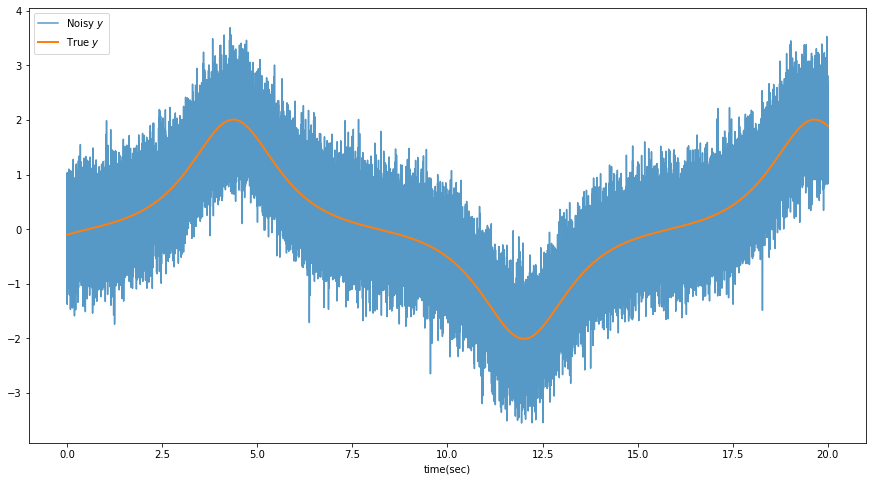

In [19]:
iteration = 0

std=0.5
ynoise = add_AWGN(y, t, std,iteration)
#Verify noise is white
print("mean = ", np.mean(ynoise - y))
print("variance = ", np.var(ynoise - y))
print("std dev = ", np.std(ynoise - y))

plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
plt.plot(t, ynoise, alpha=0.75,label="Noisy $y$")
plt.plot(t, y,  lw=2,label="True $y$")
plt.xlabel('time(sec)')
plt.legend(loc='best')
#plt.savefig('C:/Users/admin/Desktop/Noisy_y_1_150,125.pdf')
plt.show()


Seed=  0


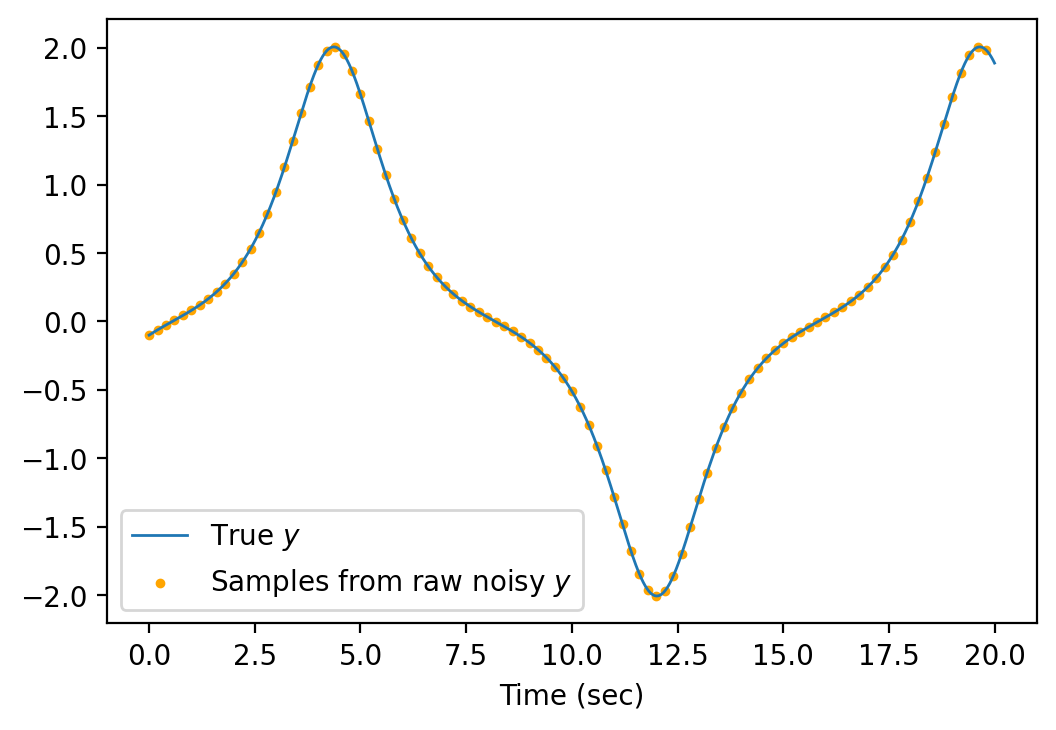

In [20]:
knots = 100
t_knots,idx = get_batch(y, t, knots, iteration=0,idx_describe=True, mode='uniform')#'random_more_at_ends')
#t_knots

#plt.figure(figsize=(15,8))
plt.figure(dpi=200)
plt.scatter(t_knots,y[idx],marker='.',s=25,color='orange',label = "Samples from raw noisy $y$")
plt.plot(t,y,lw=1,label = "True $y$")
plt.xlabel('Time (sec)')
plt.legend(loc='best')

In [21]:
# Calculate SNR
signal_power = np.mean(np.square(y))
noise_power = np.mean(np.square(y - ynoise))
SNR = signal_power/noise_power
SNR_dB = 10*np.log10(SNR)
print('SNR_dB= ', SNR_dB)
print('SNR= ', SNR)

SNR_dB=  6.29517494631005
SNR=  4.261058480063465





Calculating get_PQ function


Rank of the Matrix P is :  4



a_est=  [ 0.22873953 -0.0490381   1.50769399 -0.26204264]
Wall time: 16.1 s


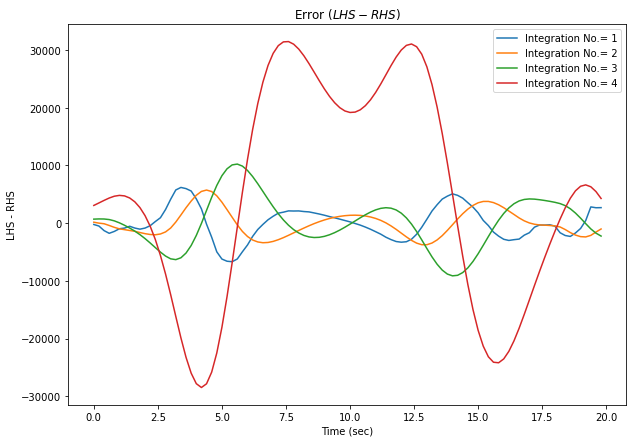

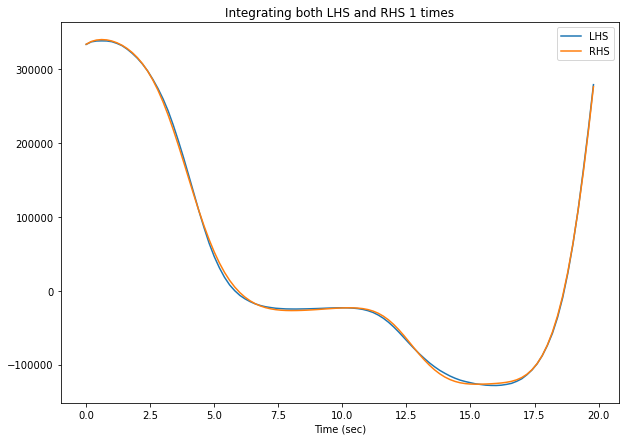

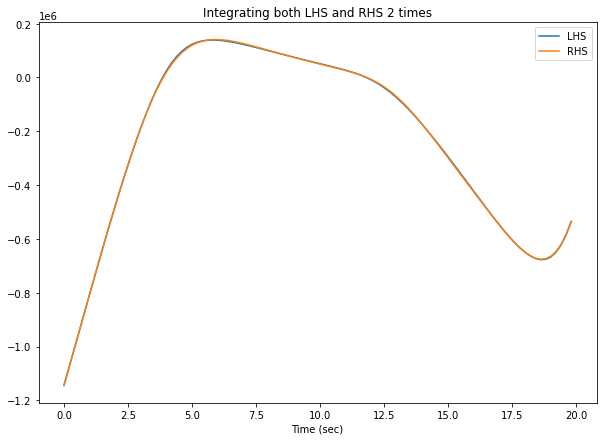

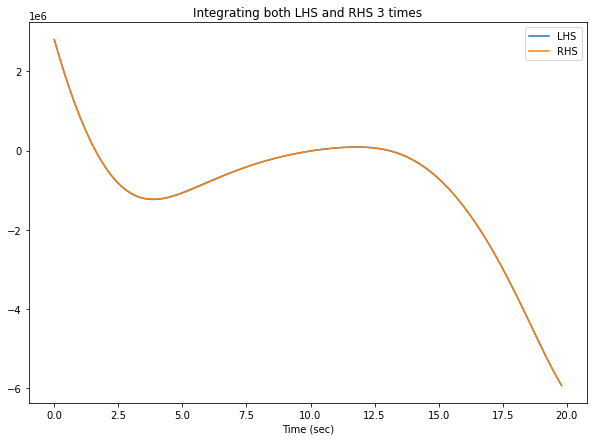

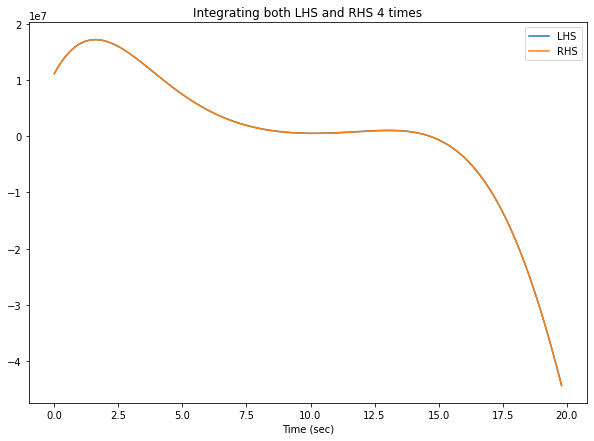

In [22]:
%%time
P, Q = get_P_Q(ynoise, t, t_knots, a, b, order=4,n_min=1,
               n_max=5, describe=False, plot=True)
Pin = np.linalg.pinv(P)
a_est = np.matmul(Pin, Q)
print('\n')
print('\na_est= ', a_est)

[0. 0. 0. 0.]
[-13.68749648 240.89200124  51.02266834   5.80634969]


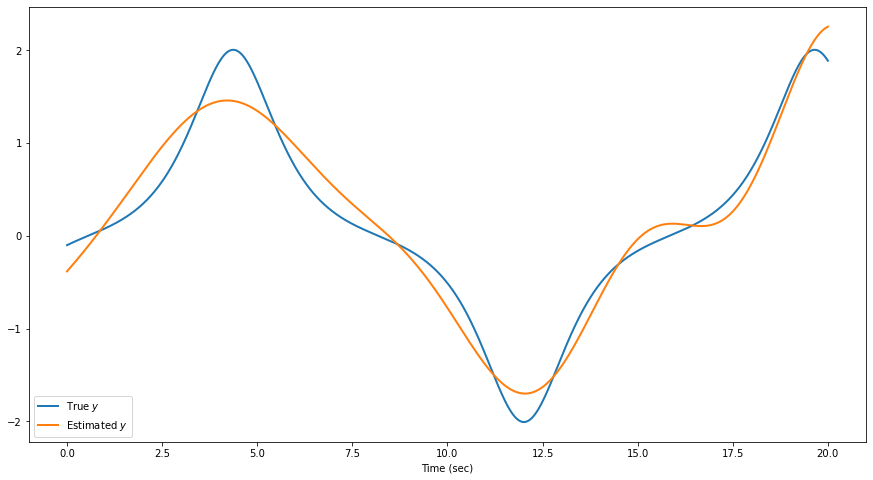

MAD= 0.5524645386714009
Variance 0.2960616425757948
RMSD=  0.21703170715189327
RMSD noise=  0.5441164270081714
BIC=  -72987.03577539301


In [23]:
a_est=np.array([0.22873953, -0.0490381,   1.50769399, -0.26204264
])

j=a_est.shape[0] #Order
yE3=np.zeros((t.shape[0],1))
e = calculate_e(gen_nth_order_LTI_sys, a_est, t) 
arra=np.dot(ynoise,e[0])
for k in range(1,j):
    arra= np.append(arra,np.dot(ynoise,e[k]))
print(arra)
yE3=np.dot(arra,e)
#print(ak1)

plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
#plt.scatter(t, ynoise, label="Measured $y$", alpha=0.01, color='y')
plt.plot(t, y, lw=2,label="True $y$")
plt.plot(t, yE3, lw=2,label="Estimated $y$")
#plt.plot(t,yE[:,j-order_min],lw=0.5,label="OLS Estimate")
plt.xlabel('Time (sec)')
plt.legend(loc='lower left')
plt.show()

MAD = 0.0
for i in range(t.shape[0]):
    if abs(y[i]-yE3[i]) > MAD:
        MAD = abs(y[i]-yE3[i])
print('MAD=', MAD)
var = np.var(ynoise - yE3)
print('Variance',var)
rms = np.sqrt(np.mean(np.square(yE3-y)))
print('RMSD= ',rms)
rms_ = np.sqrt(np.mean(np.square(yE3-ynoise)))
print('RMSD noise= ',rms_)
BIC= t.shape[0]*np.log(np.mean(np.square(yE3-ynoise)))+j*np.log(t.shape[0])
print('BIC= ',BIC)

In [24]:
order_min=2
order_max=6
i=0
a__est=np.zeros((order_max,order_max-order_min))
for order_ in range(order_min,order_max):
    P, Q = get_P_Q(ynoise, t, t_knots, a, b, order=order_, n_min=1,
               n_max=order_+2, describe=False, plot=False)
    Pin = np.linalg.pinv(P)
    a__est[:order_,i] = np.matmul(Pin, Q)
    print('est',np.matmul(Pin, Q))
    i+=1




Calculating get_PQ function


Rank of the Matrix P is :  2
est [ 0.18616237 -0.00284057]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [0.1862402  0.14846117 1.0013404 ]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [ 0.23451263 -0.04202463  1.54240674 -0.22101969]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [0.0534793  0.25428723 0.3109316  1.63334501 0.02637978]


In [27]:
yE=np.zeros((t.shape[0],order_max-order_min))
j=0
for i in range(order_min,order_max):
    ak1=a__est[:i,j]
    e = calculate_e(gen_nth_order_LTI_sys, ak1, t) 
    arra=np.dot(ynoise,e[0])
    for k in range(1,i):
        arra= np.append(arra,np.dot(ynoise,e[k]))
    print(arra)
    yE[:,j]=np.dot(arra,e)
    j+=1

[0. 0.]
[-89.19393609 218.91295506]
[0. 0. 0.]
[ 11.89190385 236.13629083  13.56590408]
[0. 0. 0. 0.]
[-34.03559225 242.25418526  27.66597528  27.16067546]
[0. 0. 0. 0. 0.]
[156.66975743 173.17764703  66.32408583  23.7729061   50.8493776 ]


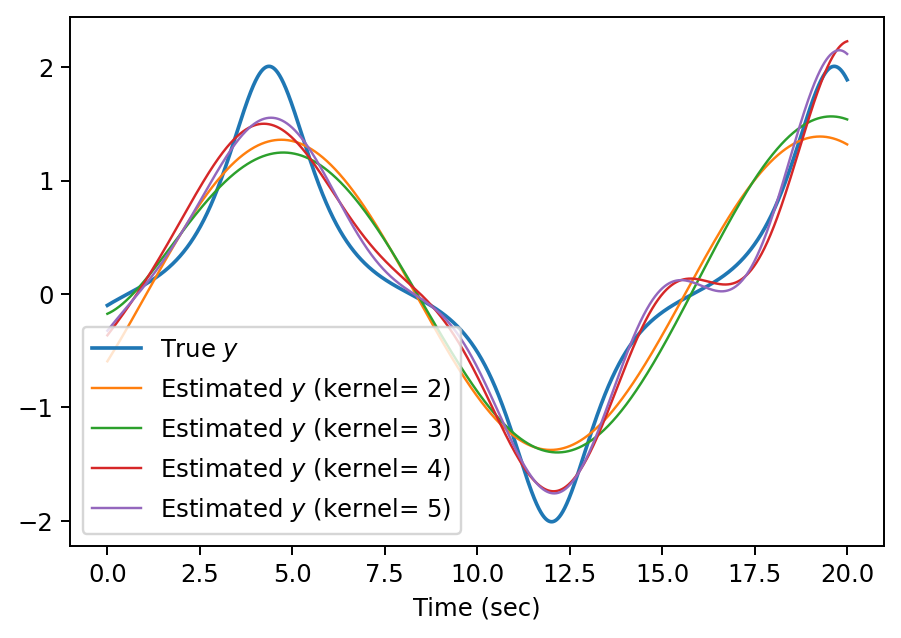

In [28]:
#plt.figure(figsize=(15,8))
plt.figure(dpi=175)
plt.plot(t,y,label='True $y$')
for i in range(0,order_max-order_min):
    lab='Estimated $y$ (kernel= '+str(i+order_min)+')'
    plt.plot(t,yE[:,i],lw=1,label=lab)
    plt.xlabel('Time (sec)')
    plt.legend()
plt.show()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y (sd=5 60k).pdf')

In [29]:
for i in range(order_max-order_min):
    bic = t.shape[0]*np.log(np.mean(np.square(yE[:,i]-ynoise)))+(i+order_min)*np.log(t.shape[0])
    print('BIC= ',bic)

BIC=  -58194.69906505823
BIC=  -58733.36046965136
BIC=  -74683.72387518774
BIC=  -77289.65341763692


[ 0.18616237 -0.00284057  0.          0.          0.          0.        ]


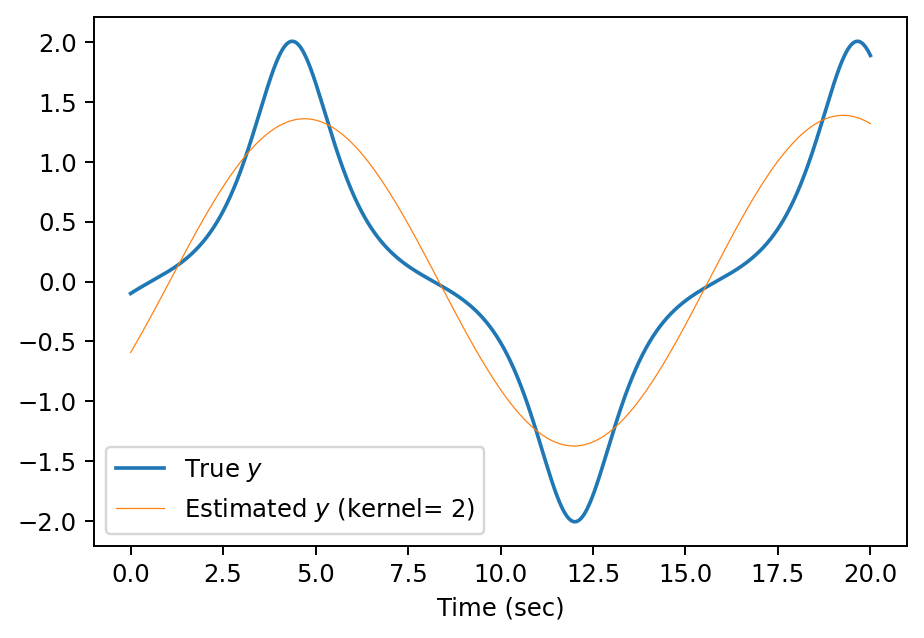

[0.1862402  0.14846117 1.0013404  0.         0.         0.        ]


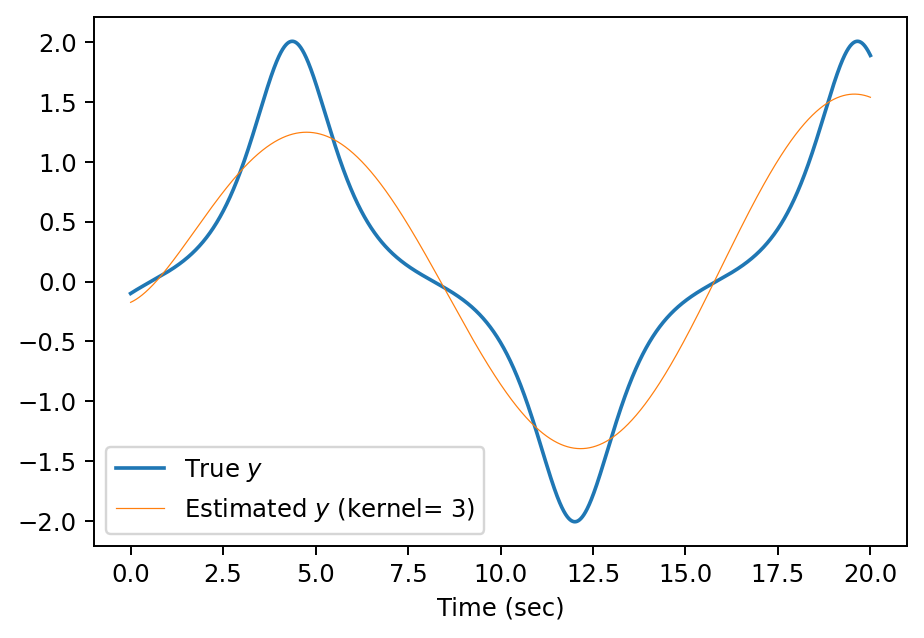

[ 0.23451263 -0.04202463  1.54240674 -0.22101969  0.          0.        ]


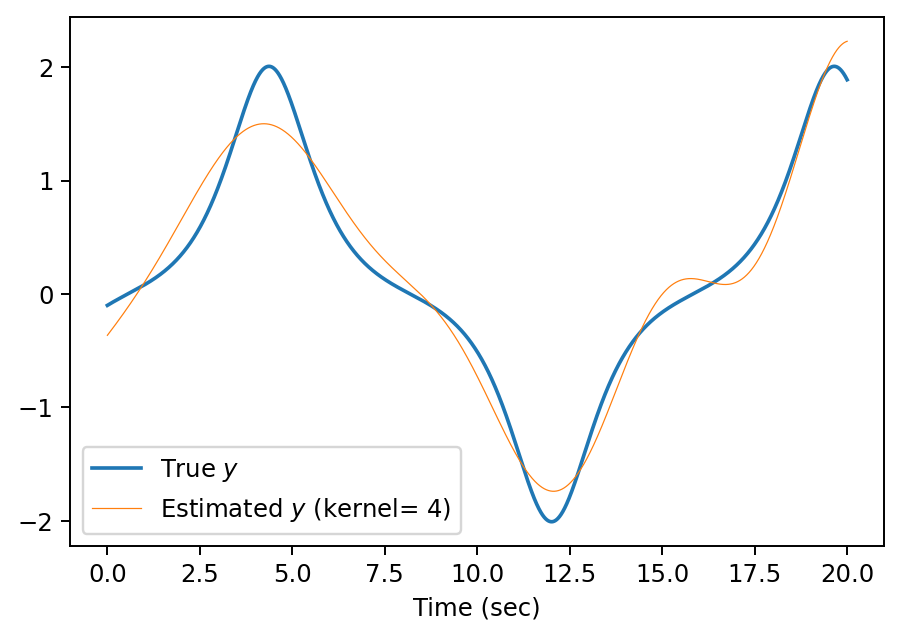

[0.0534793  0.25428723 0.3109316  1.63334501 0.02637978 0.        ]


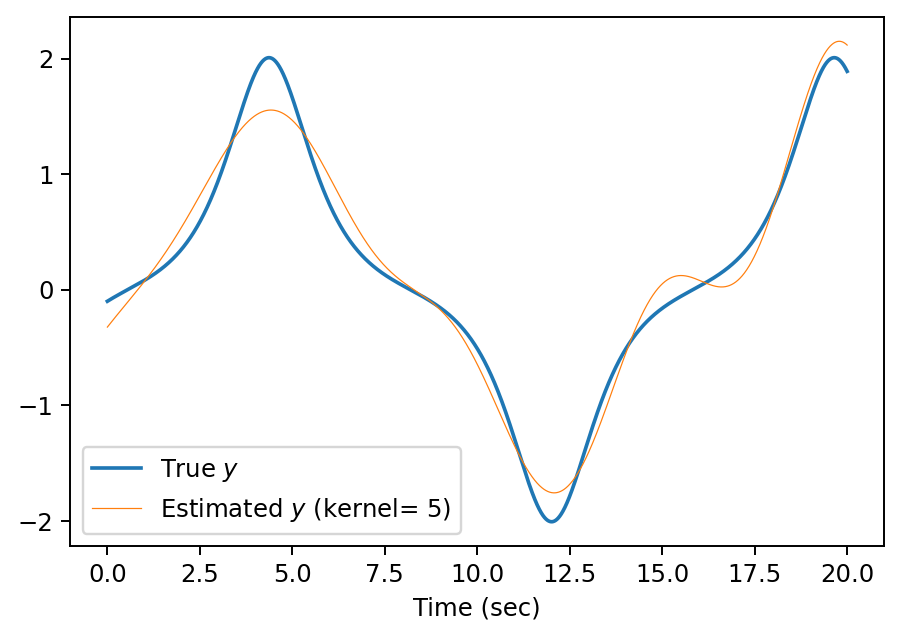

In [30]:
#plt.figure(figsize=(20,8))
for i in range(0,order_max-order_min):
    print(a__est[:,i])
    plt.figure(dpi=175)
    plt.plot(t,y,label='True $y$')
    lab='Estimated $y$ (kernel= '+str(i+order_min)+')'
    plt.plot(t,yE[:,i],lw=0.5,label=lab)
    plt.xlabel('Time (sec)')
    plt.legend()
    plt.show()

In [31]:
knots = 500
mode = 'random'
tol = 0.1
j=5 #Order

a_est=a__est[:j,j-order_min] #Need to change regularly
#a_est=np.array([1.14699527e+00,  4.64108891e+00 , 5.06443814e+00, -3.65950127e-03])

ak1, aklog1 = RLS(ynoise, t, a, b, knots, mode,
                  a_est, tol, order=j,n_min=1, n_max=j+2, var=std)

yE3=np.zeros((t.shape[0],1))
e = calculate_e(gen_nth_order_LTI_sys, ak1, t) 
arra=np.dot(ynoise,e[0])
for k in range(1,j):
    arra= np.append(arra,np.dot(ynoise,e[k]))
print(arra)
yE3=np.dot(arra,e)
print(ak1)


plt.figure(figsize=(15, 8))
#plt.scatter(t, ynoise, label="Measured $y$", alpha=0.01, color='y')
plt.plot(t, y, label="True $y$")
plt.plot(t, yE3, lw=2,label="Estimated $y$ Kernel=4")
plt.plot(t,yE[:,j-order_min],lw=0.5,label="OLS Estimate")
plt.xlabel('Time (sec)')
plt.legend()
plt.show()

MAD_OLS = 0.0
for i in range(t.shape[0]):
    if abs(y[i]-yE[:,j-order_min][i]) > MAD_OLS:
        MAD_OLS = abs(y[i]-yE[:,j-order_min][i])
print('MAD_OLS=', MAD_OLS)

MAD = 0.0
for i in range(t.shape[0]):
    if abs(y[i]-yE3[i]) > MAD:
        MAD = abs(y[i]-yE3[i])
print('MAD=', MAD)

rms_= np.sqrt(np.mean(np.square(yE[:,j-order_min]-y)))
print('RMSD _OLS= ',rms_)

rms = np.sqrt(np.mean(np.square(yE3-y)))
print('RMSD= ',rms)


bic = t.shape[0]*np.log(np.mean(np.square(yE3-ynoise)))+j*np.log(t.shape[0])
print('BIC= ',bic)


Seed=  0
0 [0.0534793  0.25428723 0.3109316  1.63334501 0.02637978]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  5
1 7

S shape=  (3000, 3000)
******


1 [0.08058288 0.24974045 0.49993126 1.62851045 0.16505953]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  5
1 7


KeyboardInterrupt: 

[0. 0. 0. 0. 0.]
[146.03732361 190.85854124  28.82397379  30.31125173  53.48570181]


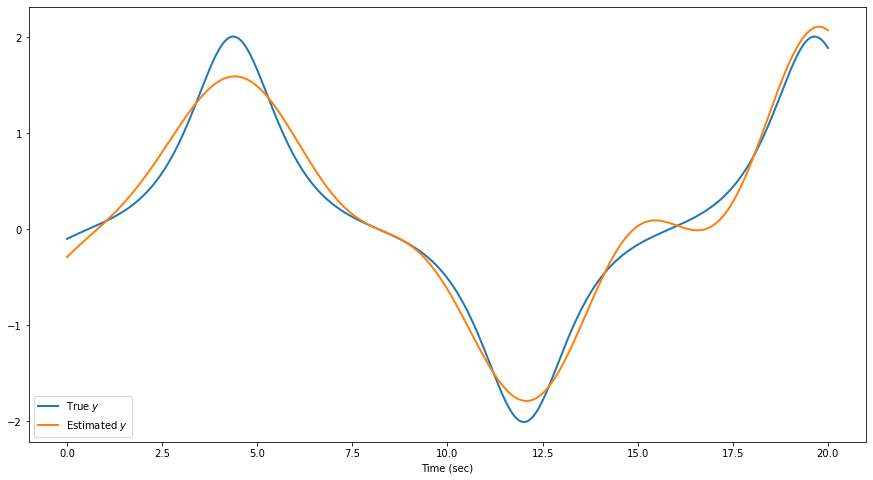

MAD= 0.41541912536348846
Variance 0.27086597279212904
RMSD=  0.14908205039505223
RMSD noise=  0.5204628544639229
BIC=  -78309.40052999288


In [32]:
a_est=np.array([0.08058288, 0.24974045, 0.49993126, 1.62851045, 0.16505953
])

j=a_est.shape[0] #Order
yE3=np.zeros((t.shape[0],1))
e = calculate_e(gen_nth_order_LTI_sys, a_est, t) 
arra=np.dot(ynoise,e[0])
for k in range(1,j):
    arra= np.append(arra,np.dot(ynoise,e[k]))
print(arra)
yE3=np.dot(arra,e)
#print(ak1)

plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
#plt.scatter(t, ynoise, label="Measured $y$", alpha=0.01, color='y')
plt.plot(t, y, lw=2,label="True $y$")
plt.plot(t, yE3, lw=2,label="Estimated $y$")
#plt.plot(t,yE[:,j-order_min],lw=0.5,label="OLS Estimate")
plt.xlabel('Time (sec)')
plt.legend(loc='lower left')
plt.show()

MAD = 0.0
for i in range(t.shape[0]):
    if abs(y[i]-yE3[i]) > MAD:
        MAD = abs(y[i]-yE3[i])
print('MAD=', MAD)
var = np.var(ynoise - yE3)
print('Variance',var)
rms = np.sqrt(np.mean(np.square(yE3-y)))
print('RMSD= ',rms)
rms_ = np.sqrt(np.mean(np.square(yE3-ynoise)))
print('RMSD noise= ',rms_)
BIC= t.shape[0]*np.log(np.mean(np.square(yE3-ynoise)))+j*np.log(t.shape[0])
print('BIC= ',BIC)

# Moving Window implementation

t_window size: 3000
start 0
stop 1
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [34.92693913  4.21098885]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [-621.38805826   11.79090473    9.1727105 ]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [620.06806189 872.06120044 291.81160172  10.22475705]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [1.18678966e+05 7.33216502e+03 3.07915103e+02 1.71332766e+02
 1.10104731e+01]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4328.44444680193
BIC=  -4326.463072609656
BIC=  -4319.633842006698
BIC=  -4311.86817050164
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [40.68532037  4.14893095]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [42.39479848  4.23661424]

Seed=  2



Calculating get_PQ function


Rank 




Calculating get_PQ function


Rank of the Matrix P is :  4
est [ 7038.04694962 -7109.42400333   271.99767981    15.49628529]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [-1.52325982e+05  1.42751124e+05  9.08123946e+03  1.08369196e+03
  2.43525232e+00]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4231.635048623528
BIC=  -4224.09275347895
BIC=  -4216.334642150553
BIC=  -4208.707528519313
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [ 9.0739925  -9.86680468]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [ 8.79203945 -9.59371831]

Seed=  2



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


3 [ 8.67357513 -9.4797186 ]

Seed=  3



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


4 [ 8.6097507  -9.41854373]
**************Reconstructing signal ****

[0. 0. 0. 0. 0.]
BIC=  -4130.747591042187
BIC=  -4123.2560050553575
BIC=  -4122.586504280046
BIC=  -4115.802717942556
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [0.58856607 1.89684231]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [0.58813937 1.90088329]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 4.0
stop 5.0
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [ 0.99251476 -0.03130926]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [-42.83692352  53.8646572  -42.68439084]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [ 433.60962201 -189.62849314  478.28375434   -3.63902499]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [-2718.79021088 11959.23182917 -3999.0672907    333.55887758
   -13.417




Calculating get_PQ function


Rank of the Matrix P is :  4
est [-6176.90051792 -6973.14614676    99.2359552    -33.69352165]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [1.25983081e+05 1.42549755e+05 9.97929444e+02 1.01662631e+03
 4.93495905e+00]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4179.33676409882
BIC=  -4173.1152772014475
BIC=  -1349.826926433052
BIC=  -4160.314262186626
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [-3.55582904 -3.39454655]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [-3.5359334  -3.37984634]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 6.0
stop 7.0
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [-0.1492906   0.13712668]



Calculating get_PQ function


Rank of the Matrix P is :  



Calculating get_PQ function


Rank of the Matrix P is :  5
est [-1.44743423e+05  1.48573423e+04  1.80882545e+04  5.30068455e+02
  5.09404702e+01]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4210.414870792913
BIC=  -4202.6480952810925
BIC=  -4194.5004950184275
BIC=  -4190.985087358801
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [11.77047341  2.01757808]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [11.75081937  2.01879863]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 7.75
stop 8.75
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [-17.70506863   2.99904168]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [-408.89589946   89.99519172   56.85915542]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [-

est [-1.60669332e+05  1.62129625e+05 -5.54555165e+03  1.01089521e+03
 -1.51918357e+01]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4088.5906871301213
BIC=  -4086.121750377492
BIC=  -2535.9798136100326
BIC=  -4072.8870851300694
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [ 13.05448076 -15.22425409]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [ 12.979375   -15.15910073]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 9.5
stop 10.5
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [ 86.33494859 -92.01631924]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [-238.1227326   239.08648898    7.47632802]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [-1082.84853922   944.87026592   195.21368876    13.9938614



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [ 1.59294477 -1.85868751]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [ 1.59382404 -1.86056534]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 11.25
stop 12.25
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [ 0.98440813 -1.57142355]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [12.21854363  0.56557893 15.07428976]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [ 247.28077763 -671.33765163  143.14296593   -5.3451844 ]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [-3.67631592e+03  2.45246466e+04  9.25466357e+02  5.60439934e+02
  1.52036820e+00]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4127.984147521982
BIC=  -4120.766268799422
BIC=  -4113.7906094619

[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4222.56779322876
BIC=  -4214.33746824954
BIC=  -4212.006654195836
BIC=  3389.428345264919
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [ 0.04661604 -0.22034342]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [ 0.04691521 -0.21997246]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 13.25
stop 14.25
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [47.12362005 49.60028941]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [198.31153135 200.34149229  -5.00929141]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [3761.090187   4032.57043055  191.9247999    16.06614241]



Calculating get_PQ function


Rank of the Matrix P is :  5
est [ 34706.38214597  27532.3736744  -10746.36




Calculating get_PQ function


Rank of the Matrix P is :  5
est [2.75578934e+05 1.66113572e+05 4.92426994e+03 8.61362360e+02
 3.56438202e+00]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4095.4354336061124
BIC=  -4088.7510750293554
BIC=  -4080.396884213305
BIC=  -4072.609728927208
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [-1.88374456 -0.31081763]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [-1.93031277 -0.33742775]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 15.0
stop 16.0
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [-0.03019934  0.7240542 ]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [443.80240796 164.39214091 -25.53026067]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [2463.98785




Calculating get_PQ function


Rank of the Matrix P is :  5
est [  7551.51068641 -30070.21080755  63443.43841643   1073.08702978
    134.479021  ]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4221.932398115448
BIC=  -4214.10396078525
BIC=  -4211.34367142027
BIC=  -4203.958092389428
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [ 4.09579824 -4.90731118]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [ 4.11836334 -4.94001752]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 17.0
stop 18.0
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
est [-16.26607831  14.93774348]



Calculating get_PQ function


Rank of the Matrix P is :  3
est [ 228.51998156 -268.33370784   41.21216376]



Calculating get_PQ function


Rank of the Matrix P is :  4
est [ 338

[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
BIC=  -4158.893552221326
BIC=  3103.38524563556
BIC=  -4145.537965329845
BIC=  -4138.742646674756
0 [0. 0.]

Seed=  0



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


1 [  7.58535955 -13.13909745]

Seed=  1



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


2 [  7.79150827 -13.50735964]

Seed=  2



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


3 [  7.90747383 -13.71413877]

Seed=  3



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


4 [  7.98297807 -13.84860652]

Seed=  4



Calculating get_PQ function


Rank of the Matrix P is :  2
2 5

S shape=  (9, 9)
******


5 [  8.03648295 -13.94381177]
**************Reconstructing signal **********************
[0. 0. 0.]
YE size: 3000
t_window size: 3000
start 18.75
stop 19.75
YM_window size: 3000

Seed=  0



Calculating get_PQ function


Rank 

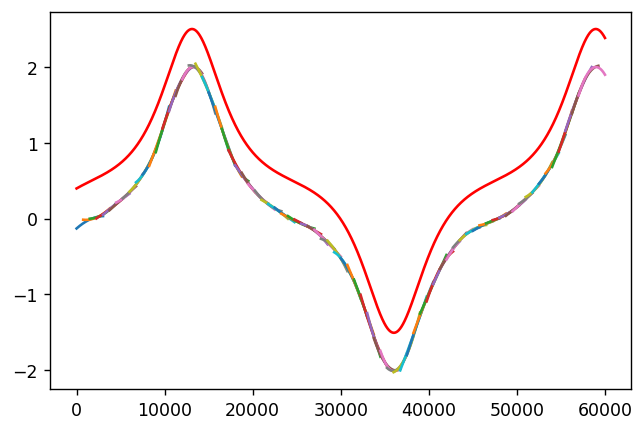

In [40]:
t_=t*(t.shape[0]//(b-a))
n_min=2
n_max = 5
order=3 #just for time being...of no use
knots = 500
mode = 'three_knots'#'three_knots'#"single_random"
tol = 0.1
window_size=1#4
window_shift=0.25#1
end = b-window_shift

#for logging
ltv_a=[]
t_window_log=[]
yE_window_log=[]
yM_window_log= []
yM=ynoise

#initialize
start=0#a=0
stop=start+window_size#b = a + window_size

plt.figure(dpi=125)
plt.plot(t_,y+0.5,'r')

while(stop <= end):        
    stop = start + window_size    
    
    #this part is to section the signal into smaller horizons
    t_window = np.where((t>=start) & (t<=stop))[0]
    print("t_window size:",t_window.size)
    print('start',start)
    print('stop',stop)
    t_new = np.linspace(start,stop,t_window.size)
    yM_window = np.take_along_axis(yM, t_window, 0)
    print("YM_window size:",yM_window.size)

    #This is to use the previous estimate as an initial condition to the next one
    ak_init=np.array([0.0, 0.0,0.0])#ak1
    ak1, aklog1 = RLS_mod(yM_window, t_new, start, stop, knots, mode, ak_init, tol, order,n_min,n_max,var=std)
    #RLS(y, t, a, b, knots, mode, ak, tol, n_min=1, n_max=5, var=1)
    print("**************Reconstructing signal **********************")
    e = calculate_e(gen_nth_order_LTI_sys, ak_init, t_new) #get_yE(yM_window, t_new, ak1)
    arra=np.dot(yM_window,e[0])
    for k in range(1,order):#1,order
        arra= np.append(arra,np.dot(yM_window,e[k]))
        #print(arra)
    yE_1=np.dot(arra,e)
    print("YE size:",yE_1.size)

    #logging and plotting
    ltv_a.append(ak1)
    yE_window_log.append(yE_1)
    t_window_log.append(t_window)
    
    plt.plot(t_window, yE_1)

    #shift the window by half
    start = start + window_shift

plt.show()

In [41]:
t_new=[]
yE_new=[]
for i in range(len(t_window_log)):
    t_new.append(t_window_log[i][-1])
    yE_new.append(yE_window_log[i][-1])

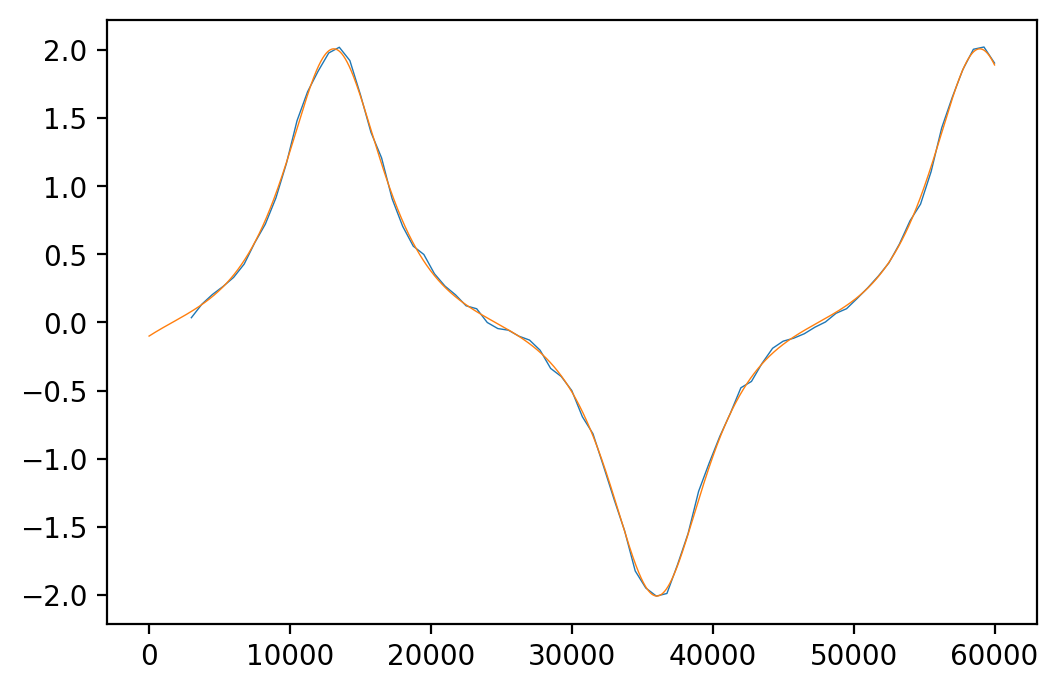

In [42]:
plt.figure(dpi=200)
plt.plot(t_new,yE_new,lw=0.5)
plt.plot(t_,y,lw=0.5)

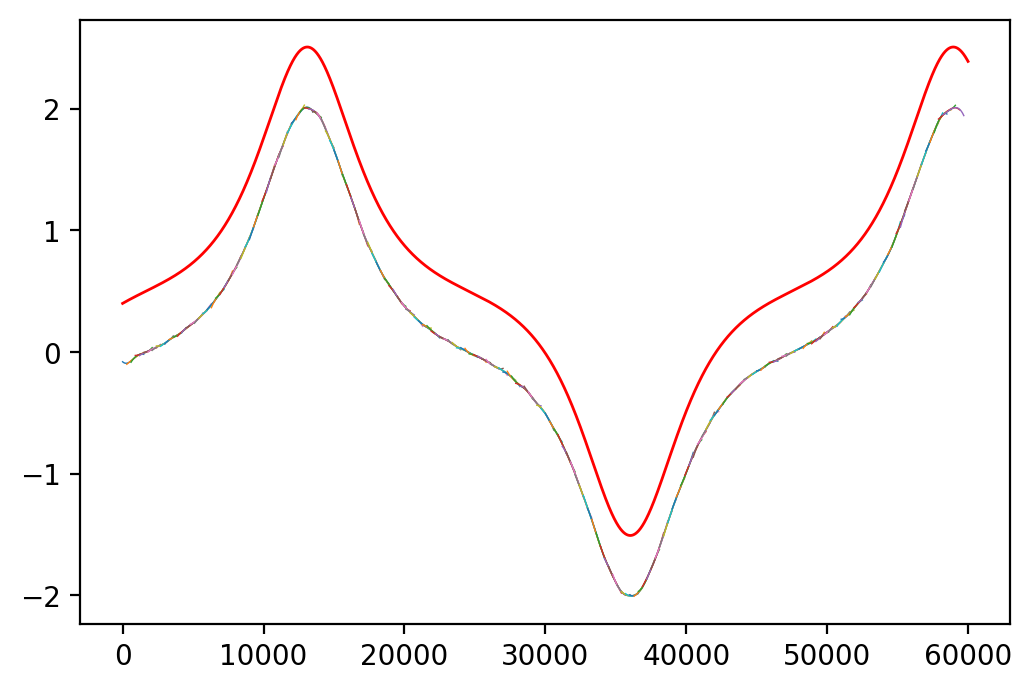

In [63]:
plt.figure(dpi=200)
plt.plot(t_,y+0.5,'r',lw=1,label='True $y$')
for i in range(len(t_window_log)):
    plt.plot(t_window_log[i], yE_window_log[i],lw=0.5)

plt.show()

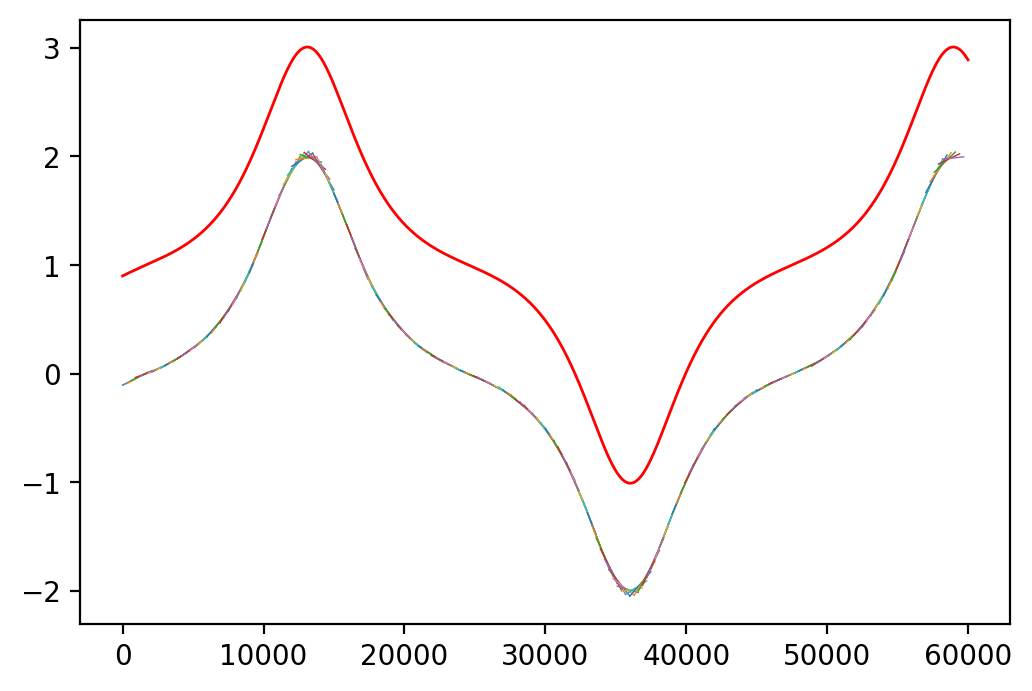

In [77]:
#2nd order window=0.5, shift=0.1
plt.figure(dpi=200)
plt.plot(t_,y+1,'r',lw=1,label='True $y$')
for i in range(len(t_window_log)):
    plt.plot(t_window_log[i], yE_window_log[i],lw=0.5)

plt.show()

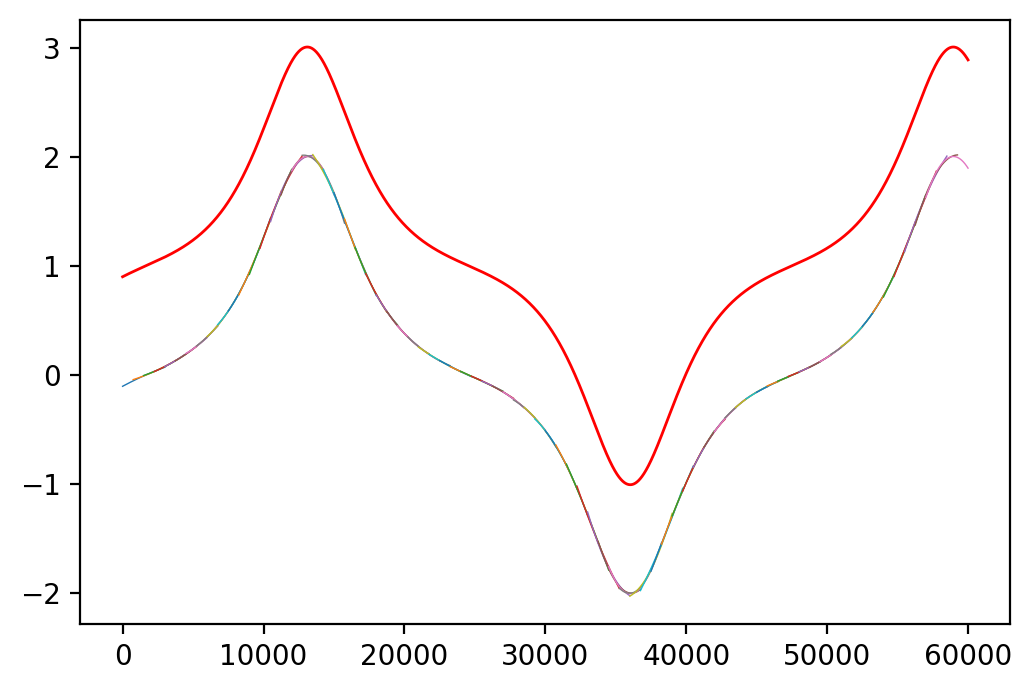

In [80]:
#3nd order window=1, shift=0.25
plt.figure(dpi=200)
plt.plot(t_,y+1,'r',lw=1,label='True $y$')
for i in range(len(t_window_log)):
    plt.plot(t_window_log[i], yE_window_log[i],lw=0.5)

plt.show()

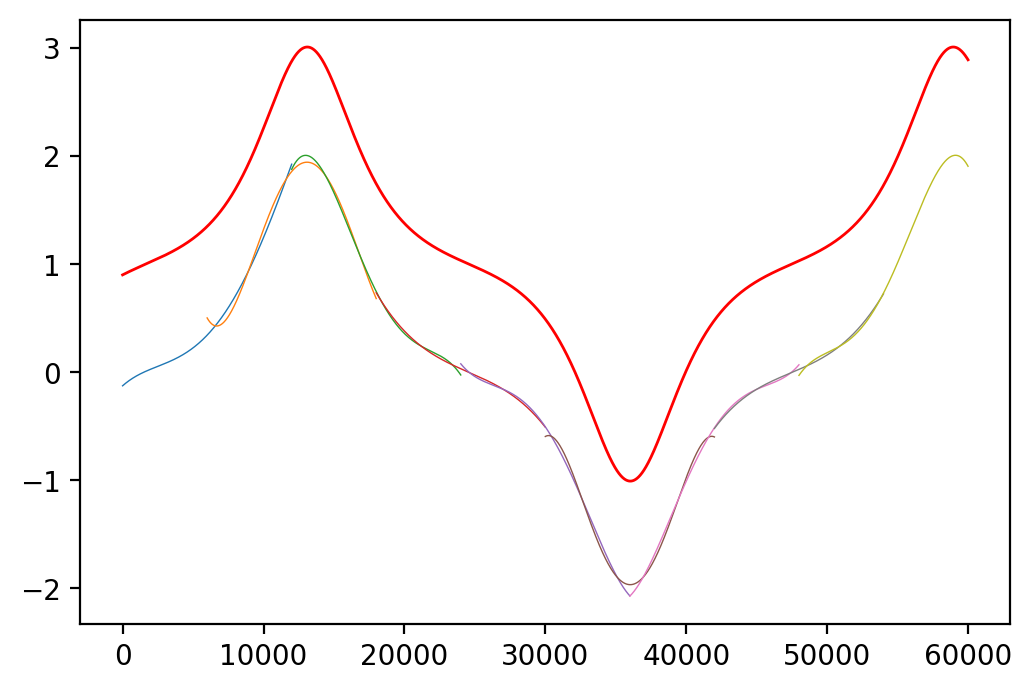

In [75]:
#5th order window=4, shift=2
plt.figure(dpi=200)
plt.plot(t_,y+1,'r',lw=1,label='True $y$')
for i in range(len(t_window_log)):
    plt.plot(t_window_log[i], yE_window_log[i],lw=0.5)

plt.show()

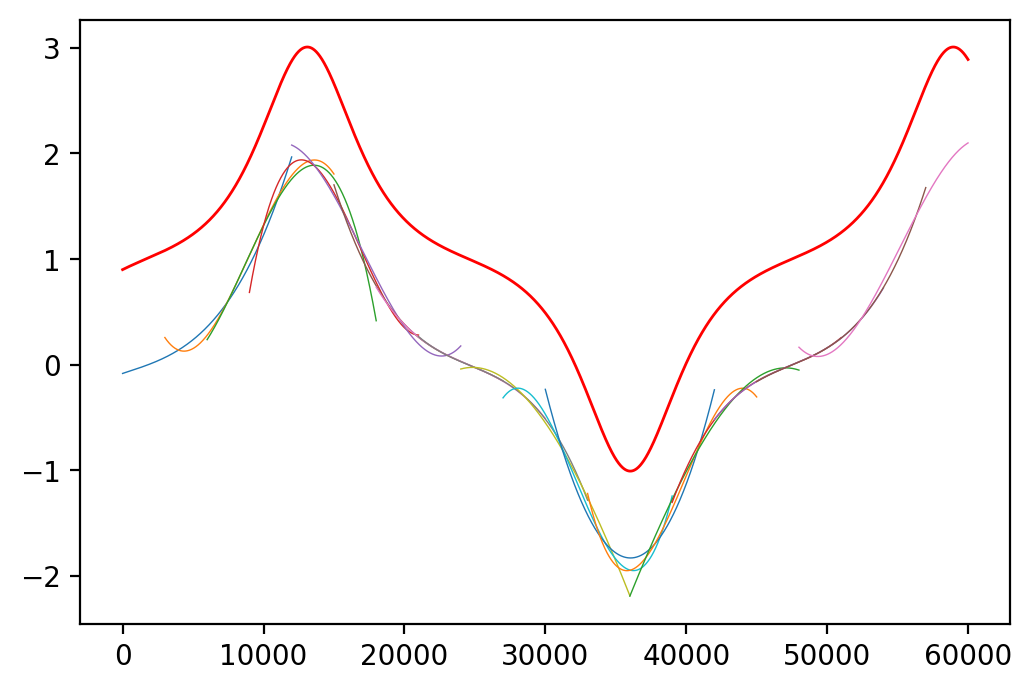

In [72]:
#4th order window=4, shift=0.1
plt.figure(dpi=200)
plt.plot(t_,y+1,'r',lw=1,label='True $y$')
for i in range(len(t_window_log)):
    plt.plot(t_window_log[i], yE_window_log[i],lw=0.5)

plt.show()

In [27]:
def get_KFn_1_vector(ti, tau_F, a, order, derivative):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(tau_F - a)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_F)**(i))/(f(i)))
        # print('gamma',gamma)
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(j+n-p+1)) * gamma[j-1, :] * ((delta**(p-j))/f(
            p-j)) * (f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outp ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j))
                                     * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j)) * (
                    (-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                #print('i',i)
                #print('j',j)
                #print('p',p)
                #print('n',n)

                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                    (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
                #print(zeta[i,:])
    return zeta

In [28]:
def get_KBn_1_vector(ti, tau_B, b, order, derivative):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - tau_B)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_B)**(i))/(f(i)))
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(gamma[j-1, :] * ((delta**(p-j))/f(p-j)) * (
            f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outpB ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] *
                                     ((delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * (
                    (delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i)) /
                                                      f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * (
                    (delta**(n-j+p-i))/f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
    return zeta

In [29]:
def get_y_derivative(y, t, a, b, ak, order, derivative):
    f = np.math.factorial
    N = t.shape[0]
    RHS_n = np.zeros((N, order+1))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    r = 0
    for ti in t:
        #print(ti)
        #for i in range(1,11):
        if ti==t[int(t.shape[0]*(2.5/10))]:
            print('25% done')
        elif ti==t[int(t.shape[0]*(5/10))]:
            print('50% done')
        elif ti==t[int(t.shape[0]*(7.5/10))]:
            print('75% done')
        elif ti==t[int(t.shape[0]*(9.9/10))]:
            print('99% done')
        
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate Kernel vector
        # alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n=1) #(t-a)**4+(b-t)**4
        KFn_vector = get_KFn_1_vector(ti, tau_F, a, order, derivative)
        KBn_vector = get_KBn_1_vector(ti, tau_B, b, order, derivative)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)
        # Calculate integrands
        integrand = np.multiply(KDSn_vector, y)
        # print(integrand)
        # print('*'*10)
        integrand = np.multiply(beta, integrand)

        # Integrate
        for k in range(0, order+1):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
        r += 1
        KDSn = np.sum(RHS_n, axis=1)
        # print('shape',RHS_n.shape)
    return KDSn  # RHS_n

In [30]:
def get_KF_vector(y_all, ti, a, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(ti - a)
    n = order
    k = derivative
    p = n-k

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(i+1)) * ((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (((-1)**(i+1))/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])  # p=3,i=3,j=0
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (((-1)**(j+1))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
                #print('y_est', y_all[:, i-j-p])
                #print('ti-a', delta**(n-j))
                #print('const', (((-1)**(j))/f(n-j)) * (
                 #   f(p+j-1)/(f(j)*f(p-1))) * f(n))
        print('outpu ', zeta[i, :])
        print(i)'''
    #print('beta', beta)
    ans = np.multiply(beta, zeta)
    return ans

In [31]:
def get_KB_vector(y_all, ti, b, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    #gamma = np.zeros((order, N_tau))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - ti)
    n = order
    k = derivative
    p = n-k
    # for i in range(0, order):
    #    gamma[i, :] = np.array(((ti - tau_B)**(n+i))/(f(n+i)))

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (1/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    #print('outpB ', zeta[order, :])
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                           * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (1/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
        #print('outpuB ', zeta[i, :])
        print(i)'''
    ans = -np.multiply(beta, zeta)
    return ans

25% done
50% done
75% done
99% done
MAD 1= 6.496539468429648
max pt 0


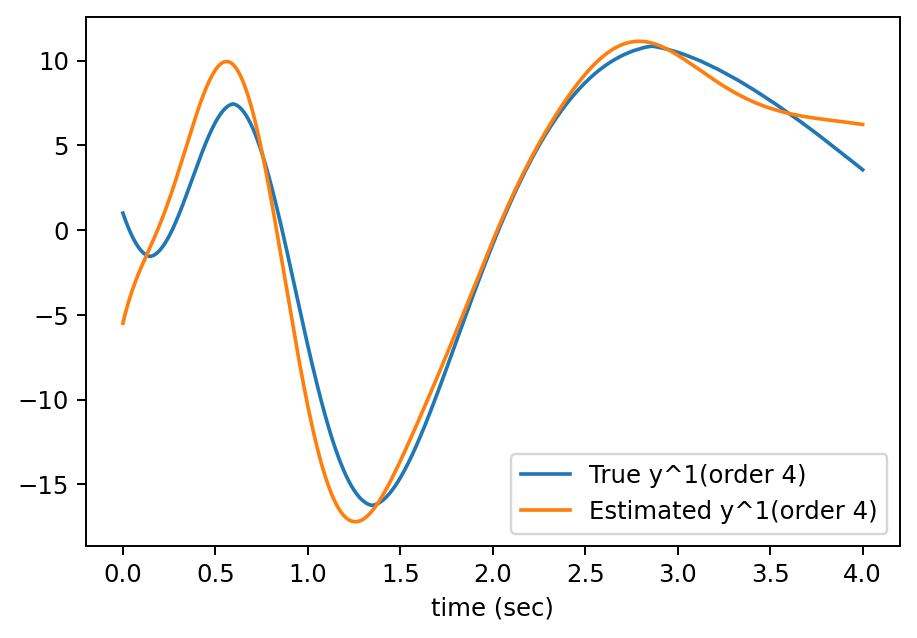

"\n\nderivative1=2\ny_all[:,1] = y_dot_est\ny_ddot_est_F_int = np.zeros_like(y_n)\ny_ddot_est_F = np.zeros_like(y_ddot_est_F_int)\ny_ddot_est_B_int = np.zeros_like(y_n)\ny_ddot_est_B = np.zeros_like(y_ddot_est_B_int)\ny_ddot_est = np.zeros_like(y_n)\nout_d = get_y_derivative(y, t, a, b, ak1, order, derivative1)\ny_ddot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative1)\ny_ddot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative1)\ny_ddot_est_KD = np.sum(y_ddot_est_F_int+y_ddot_est_B_int, axis=0)\ny_ddot_est = (y_ddot_est_KD + out_d) /     (((t-a)**order)+((b-t)**order))\n\nMAD2 = 0.0\nj=0\nfor i in range(t.shape[0]):\n    if ydotdot[i]-y_ddot_est[i] > MAD2:\n        MAD2 = ydotdot[i]-y_ddot_est[i]\n        j=i\nprint('MAD 2=', MAD2)\nprint('max pt',j)\n\n#plt.figure(figsize=(15, 8))\nplt.figure(dpi=175)\nlab_t='True y^'+str(derivative1)+'(order '+str(order)+')'\nlab_e='Estimated y^'+str(derivative1) +'(order '+str(order)+')'\nplt.plot(t, ydotdot, label=lab_t)\npl

In [79]:
# % % time


order = 4
yE[:,order-order_min]=yE3
#a__est[:order,order-order_min]=a_est

derivative = 1
ak1= a__est[:order,order-order_min]
y_all = np.zeros((y.shape[0], order))
y_all[:, 0] =  yE[:,order-order_min]
y_n = yE[:,order-order_min]
y_dot_est_F_int = np.zeros_like(y_n)
y_dot_est_F = np.zeros_like(y_dot_est_F_int)
y_dot_est_B_int = np.zeros_like(y_n)
y_dot_est_B = np.zeros_like(y_dot_est_B_int)
y_dot_est = np.zeros_like(y_n)
out = get_y_derivative(y, t, a, b, ak1, order, derivative)
y_dot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative)
y_dot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative)
y_dot_est_KD = np.sum(y_dot_est_F_int+y_dot_est_B_int, axis=0)
y_dot_est = (y_dot_est_KD + out) / \
    (((t-a)**order)+((b-t)**order))

MAD1 = 0.0
j=0
for i in range(t.shape[0]):
    if ydot[i]-y_dot_est[i] > MAD1:
        MAD1 = ydot[i]-y_dot_est[i]
        j=i
print('MAD 1=', MAD1)
print('max pt',j)


#plt.figure(figsize=(15, 8))
plt.figure(dpi=175)
lab_t='True y^'+str(derivative)+'(order '+str(order)+')'
lab_e='Estimated y^'+str(derivative) +'(order '+str(order)+')'
plt.plot(t, ydot, label=lab_t)
plt.plot(t, y_dot_est, label=lab_e)
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y_dot (sd=2 60k).pdf')
plt.show()
'''

derivative1=2
y_all[:,1] = y_dot_est
y_ddot_est_F_int = np.zeros_like(y_n)
y_ddot_est_F = np.zeros_like(y_ddot_est_F_int)
y_ddot_est_B_int = np.zeros_like(y_n)
y_ddot_est_B = np.zeros_like(y_ddot_est_B_int)
y_ddot_est = np.zeros_like(y_n)
out_d = get_y_derivative(y, t, a, b, ak1, order, derivative1)
y_ddot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative1)
y_ddot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative1)
y_ddot_est_KD = np.sum(y_ddot_est_F_int+y_ddot_est_B_int, axis=0)
y_ddot_est = (y_ddot_est_KD + out_d) / \
    (((t-a)**order)+((b-t)**order))

MAD2 = 0.0
j=0
for i in range(t.shape[0]):
    if ydotdot[i]-y_ddot_est[i] > MAD2:
        MAD2 = ydotdot[i]-y_ddot_est[i]
        j=i
print('MAD 2=', MAD2)
print('max pt',j)

#plt.figure(figsize=(15, 8))
plt.figure(dpi=175)
lab_t='True y^'+str(derivative1)+'(order '+str(order)+')'
lab_e='Estimated y^'+str(derivative1) +'(order '+str(order)+')'
plt.plot(t, ydotdot, label=lab_t)
plt.plot(t, y_ddot_est, label=lab_e)
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y_dot (sd=2 60k).pdf')
plt.show()'''

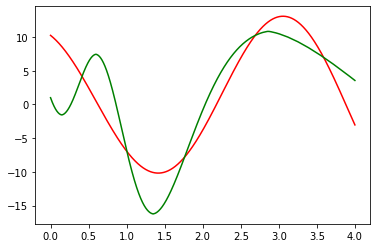

In [32]:
#ydot
dy1 = np.zeros(yE3.shape,np.float)
dy1[0:-1] = np.diff(yE3)/np.diff(t)
dy1[-1] = (yE3[-1] - yE3[-2])/(t[-1] - t[-2])
plt.plot(t,dy1,'r')
#plt.plot(t,y_dot_est)
plt.plot(t,ydot,'g')

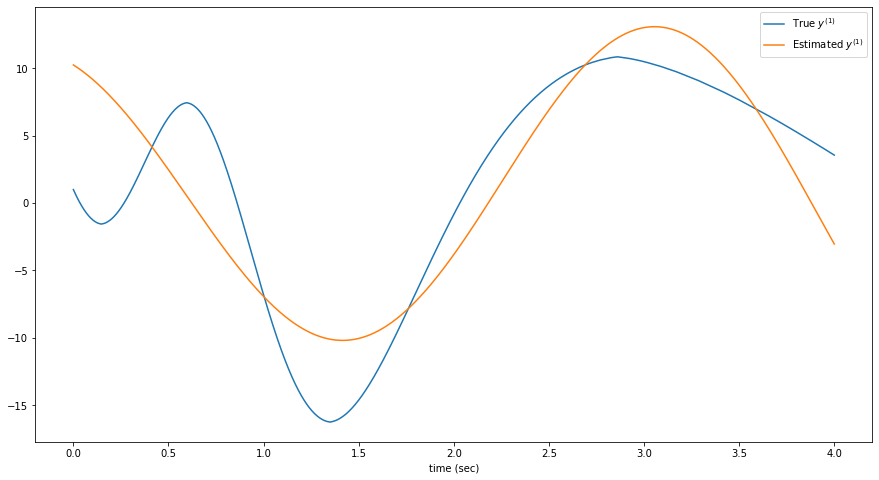

In [33]:
plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
#lab_t='True y^'+str(derivative)+'(order '+str(order)+')'
#lab_e='Estimated y^'+str(derivative) +'(order '+str(order)+')'
plt.plot(t, ydot, label='True $y^{(1)}$')
plt.plot(t, dy1, label='Estimated $y^{(1)}$')
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of ydot 150,125 (sd=1 sample=60k order=4 int=1_5).pdf')
plt.show()

In [32]:
MAD = 0.0
for i in range(t.shape[0]):
    if abs(ydot[i]-dy1[i]) > MAD:
        MAD = abs(ydot[i]-dy1[i])
print('MAD=', MAD)

rms = np.sqrt(np.mean(np.square(dy1-ydot)))
print('RMSD= ',rms)

MAD= 0.03416330362012393
RMSD=  0.019935138653714095


In [76]:
#ydotdot
dy_ = np.zeros(dy1.shape,np.float)
dy_[0:-1] = np.diff(dy1)/np.diff(t)
dy_[-1] = (dy1[-1] - dy1[-2])/(t[-1] - t[-2])

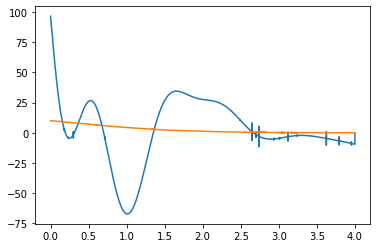

In [77]:
plt.plot(t,dy_)
plt.plot(t,ydotdot)

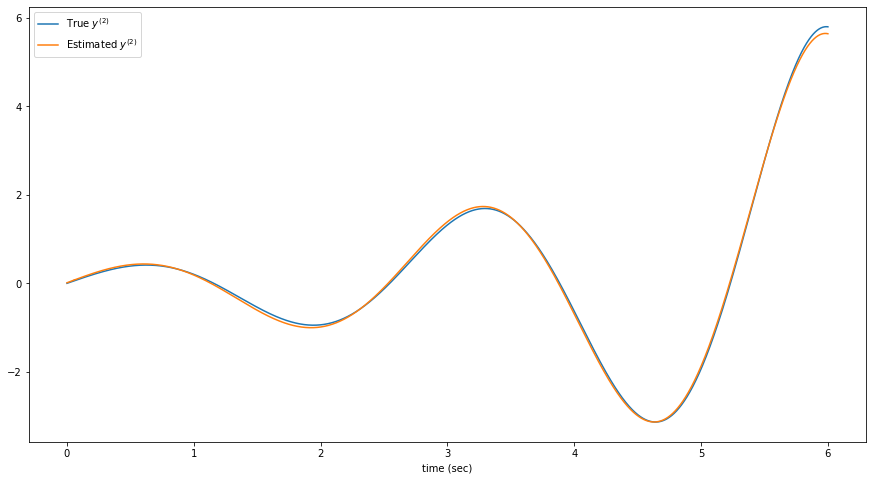

In [33]:
plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
#lab_t='True y^'+str(derivative)+'(order '+str(order)+')'
#lab_e='Estimated y^'+str(derivative) +'(order '+str(order)+')'
plt.plot(t, ydotdot, label='True $y^{(2)}$')
plt.plot(t[:-2],dy_[:-2], label='Estimated $y^{(2)}$')
plt.xlabel('time (sec)')
plt.legend()
#plt.ylim([-10,10])
#plt.savefig('C:/Users/admin/Desktop/Estimation of ydotdot 150,125 (sd=1 sample=60k order=4 int=1_5).pdf')
plt.show()

In [35]:
MAD = 0.0
for i in range(t.shape[0]-2):
    if abs(ydotdot[i]-dy_[i]) > MAD:
        MAD = abs(ydotdot[i]-dy_[i])
print('MAD=', MAD)

rms = np.sqrt(np.mean(np.square(dy_[:-2]-ydotdot[:-2])))
print('RMSD= ',rms)

MAD= 0.1564109554971438
RMSD=  0.051402740517309795


25% done
50% done
75% done
99% done
MAD 2= 3.702121621075486
max pt 59998
RMSD=  0.16738519229548543


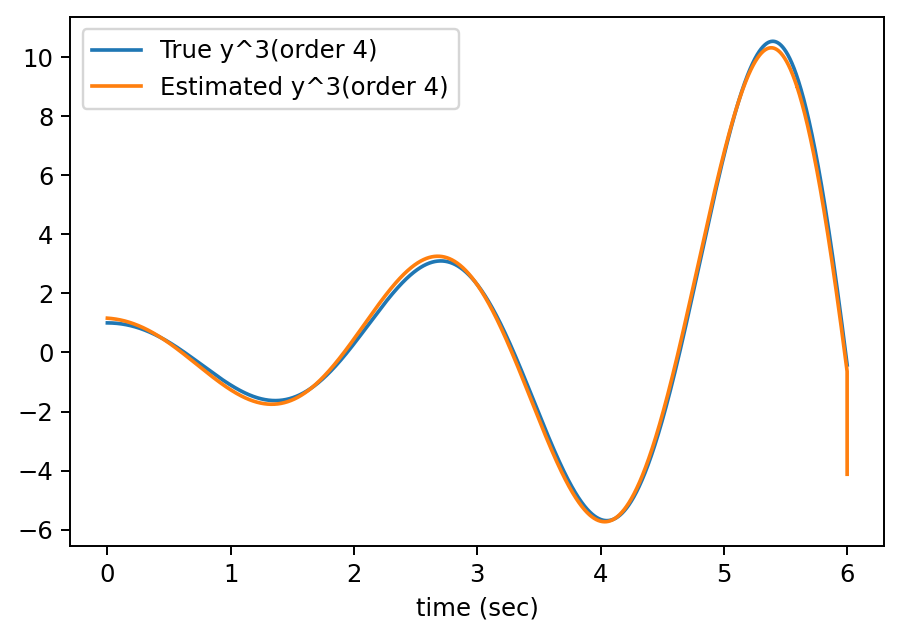

In [36]:
order = 4
#yE[:,order-order_min]=yE3
#a__est[:order,order-order_min]=a_est

derivative1=3
ak1= a_est
y_all = np.zeros((y.shape[0], order))
y_all[:, 0] =  yE3
y_n = yE3
y_all[:,1] = dy1
y_all[:,2] = dy_
y_dddot_est_F_int = np.zeros_like(y_n)
y_dddot_est_F = np.zeros_like(y_dddot_est_F_int)
y_dddot_est_B_int = np.zeros_like(y_n)
y_dddot_est_B = np.zeros_like(y_dddot_est_B_int)
y_dddot_est = np.zeros_like(y_n)
out_d = get_y_derivative(y, t, a, b, ak1, order, derivative1)
y_dddot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative1)
y_dddot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative1)
y_dddot_est_KD = np.sum(y_dddot_est_F_int+y_dddot_est_B_int, axis=0)
y_dddot_est = (y_dddot_est_KD + out_d) / \
    (((t-a)**order)+((b-t)**order))

MAD2 = 0.0
j=0
for i in range(t.shape[0]):
    if ydotdotdot[i]-y_dddot_est[i] > MAD2:
        MAD2 = ydotdotdot[i]-y_dddot_est[i]
        j=i
print('MAD 2=', MAD2)
print('max pt',j)

rms = np.sqrt(np.mean(np.square(y_dddot_est-ydotdotdot)))
print('RMSD= ',rms)

#plt.figure(figsize=(15, 8))
plt.figure(dpi=175)
lab_t='True y^'+str(derivative1)+'(order '+str(order)+')'
lab_e='Estimated y^'+str(derivative1) +'(order '+str(order)+')'
plt.plot(t, ydotdotdot, label=lab_t)
plt.plot(t, y_dddot_est, label=lab_e)
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y_dot (sd=2 60k).pdf')
plt.show()

In [37]:
MAD2 = 0.0
j=0
for i in range(t.shape[0]-2):
    if ydotdotdot[i]-y_dddot_est[i] > MAD2:
        MAD2 = ydotdotdot[i]-y_dddot_est[i]
        j=i
print('MAD 2=', MAD2)
print('max pt',j)

MAD 2= 0.3620251306734401
max pt 57197


In [38]:
rms = np.sqrt(np.mean(np.square(y_dddot_est[:-2]-ydotdotdot[:-2])))
print('RMSD= ',rms)

RMSD=  0.16601885758367682


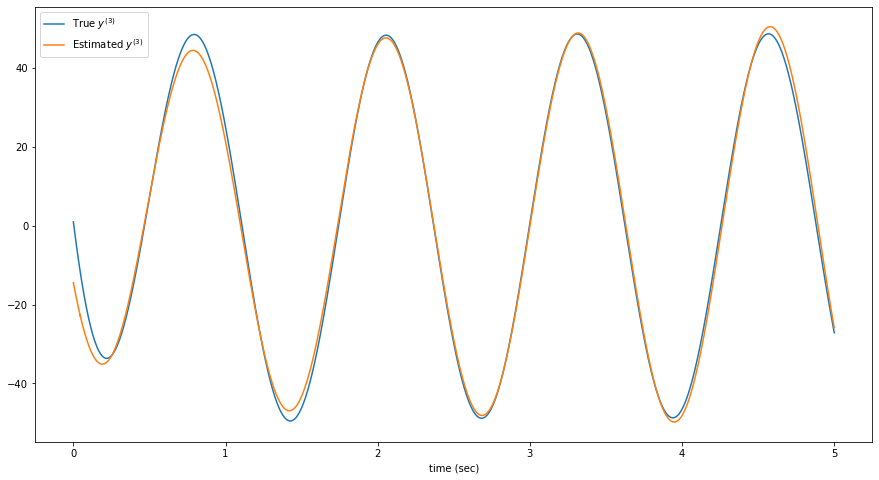

In [309]:
plt.figure(figsize=(15, 8))
#plt.figure(dpi=175)
#lab_t='True y^'+str(derivative)+'(order '+str(order)+')'
#lab_e='Estimated y^'+str(derivative) +'(order '+str(order)+')'
plt.plot(t, ydotdotdot, label='True $y^{(3)}$')
plt.plot(t[:-2],y_dddot_est[:-2], label='Estimated $y^{(3)}$')
plt.xlabel('time (sec)')
plt.legend()
plt.savefig('C:/Users/admin/Desktop/Estimation of ydddot 150,125 (sd=1 sample=60k order=4 int=1_5).pdf')
plt.show()

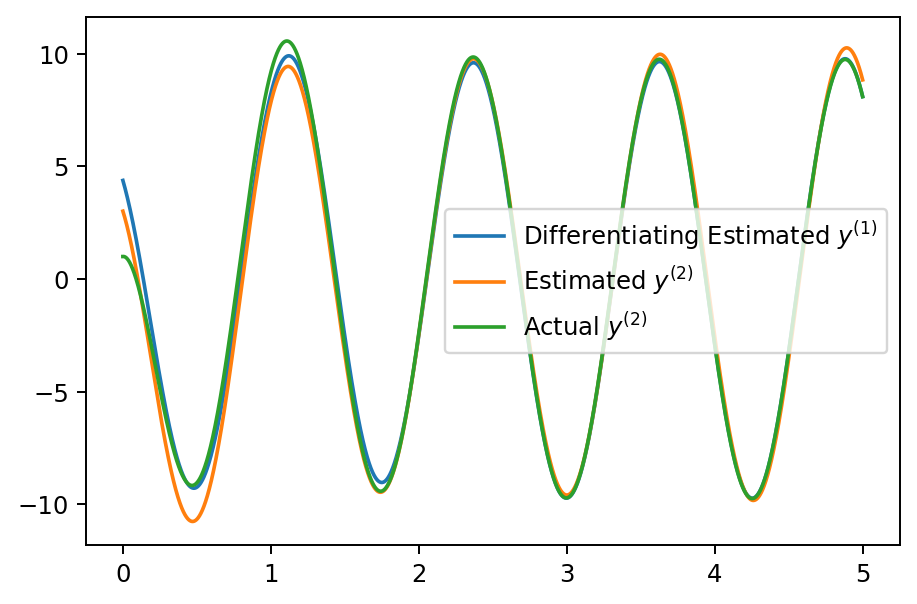

In [205]:
plt.figure(dpi=175)
plt.plot(t[:-2],dy[:-2],label='Differentiating Estimated $y^{(1)}$')
plt.plot(t,y_ddot_est,label='Estimated $y^{(2)}$')
#plt.plot(t,dy_,label='Differentiating Actual $y^{(1)}$')
plt.plot(t,ydotdot, label='Actual $y^{(2)}$')
plt.legend()
plt.show()